---
title: "Exploratory Data Analysis"
format:
    html: 
        toc: true
        code-fold: true
        embedded-resouces: true
bibliography: ../../references.bib
---

# Introduction and Motivation  

This Exploratory Data Analysis (EDA) aims to uncover critical patterns and disparities within the dataset, focusing on geographic and demographic distributions of wrongful convictions, arrests, and official misconduct. The analysis examines relationships across key variables, such as race, location, crime type, and sentencing, to highlight systemic inequities and structural flaws in the criminal justice system. By summarizing, visualizing, and analyzing the data, this EDA provides a comprehensive foundation for the following stages of the project, informing both unsupervised learning approaches, such as clustering, and supervised learning, which will predict the probability of wrongful incarceration across race, counties, and other factors. Ultimately, this work seeks to highlight systemic failures, contribute to a deeper understanding of Illinois Crime data, and underscore the significant and urgent need for data-driven reforms in our criminal justice system.

### Urban vs. Rural Classification  
Although the dataset does not explicitly label counties as urban or rural, external classification data from the [Illinois Primary Health Care Association (IPHCA)](https://dph.illinois.gov/content/dam/soi/en/web/idph/files/rur-urb-2021.pdf){target=_blank} was incorporated to provide important context for analyzing patterns in arrests, exonerations, and over-policing across Illinois counties. This visualization will be refrencfed multiple times in the following EDA, for further details, refer to **Appendix A** in the Appendix tab. [@iphca2020rural]  

![Illinois Counties by Rural/Urban Classification](../../images/rural_urban_county_classification.png)

# Univariate Analysis

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt  
import warnings 

# Load cleaned exoneration dataset
exon_df = pd.read_csv('../../data/processed-data/illinois_exoneration_data.csv')

warnings.filterwarnings("ignore", category=FutureWarning)

## Categorical Variables

### Distribution of Exonerations by Race

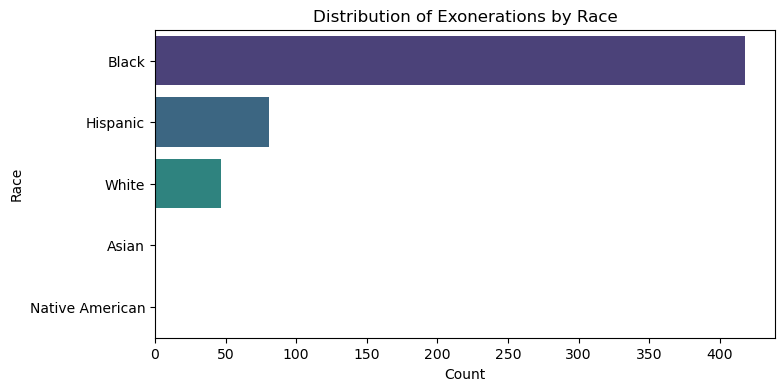

In [513]:
plt.figure(figsize=(8, 4))
sns.countplot(y=exon_df['race'], order=exon_df['race'].value_counts().index, palette='viridis')
plt.title('Distribution of Exonerations by Race')
plt.xlabel('Count')
plt.ylabel('Race')
plt.show()

In [510]:
race_counts = exon_df['race'].value_counts().reset_index()
race_counts.columns = ['Race', 'Count']
print("Table: Distribution of Race by Exoneration")
race_counts.head()

Table: Distribution of Race by Exoneration


,Race,Count
0,Black,418
1,Hispanic,81
2,White,47
3,Asian,1
4,Native American,1


**Black individuals account for the largest group of exonerees in Illinois, with 418 cases, followed by Hispanic individuals with 81 cases and White individuals with 47**. Contrastingly, Asian and Native American groups each have only 1 case**. The extremely low counts for Asian and Native American individuals are essential to note because while these groups are part of the dataset, their inclusion in further analyses—such as statistical tests or group comparisons—could **skew results** or lead to unreliable interpretations due to the disproportionately small sample sizes. To ensure the validity and accuracy of the analysis, these groups may be excluded or grouped under an "Other" category where necessary to maintain statistical integrity and avoid drawing misleading conclusions. These base findings highlight apparent disparities in exoneration rates across racial groups—a pattern that will be examined in greater detail in the following analysis.  

### Frequency of Worst Crime Display

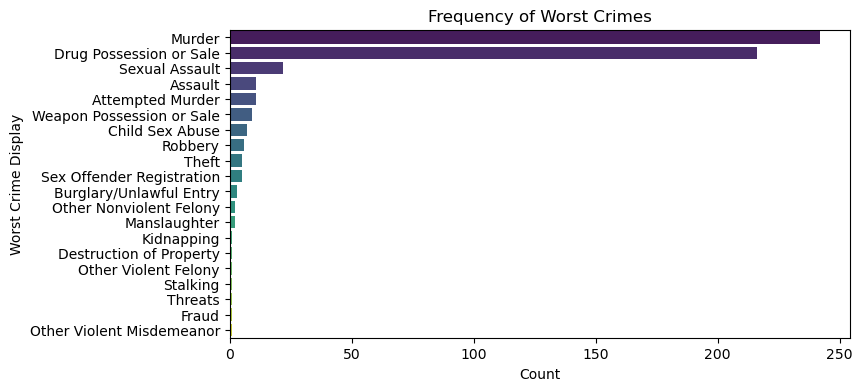

In [512]:
plt.figure(figsize=(8, 4))
sns.countplot(y=exon_df['worst_crime_display'], 
                order=exon_df['worst_crime_display'].value_counts().index, 
                palette='viridis')
plt.title('Frequency of Worst Crimes')
plt.xlabel('Count')
plt.ylabel('Worst Crime Display')
plt.show()

The bar chart above shows the distribution of "worst crimes" associated with exonerees. **Murder** overwhelmingly accounts for the largest share, followed closely by **Drug Possession or Sale** and **Sexual Assault**. Beyond these top categories, the remaining crimes—such as **Assault**, **Attempted Murder**, and **Weapon Possession or Sale**—appear far less frequently, with counts dropping off significantly. The dominance of murder cases highlights a troubling trend: the most severe crimes are also the most common among wrongful convictions. This could potentially reflect systemic pressures, including the heightened scrutiny and urgency associated with solving violent crimes, which could possibly contribute to rushed investigations, false accusations, or coerced confessions.  

The presence of **Drug Possession or Sale** as the second-highest category is equally notable, as it points to broader issues within the criminal justice system surrounding drug-related offenses, particularly the targeting of specific communities through over-policing and harsh sentencing policies.  These findings reveal clear patterns in wrongful convictions that disproportionately affect individuals accused of high-stakes or heavily policed offenses. 


### Distribution of Exonerees by Sex

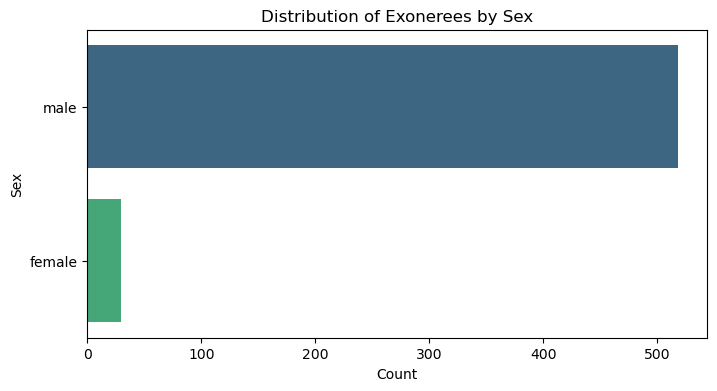

In [517]:
plt.figure(figsize=(8, 4))
sns.countplot(y=exon_df['sex'], 
                order=exon_df['sex'].value_counts().index, 
                palette='viridis')
plt.title('Distribution of Exonerees by Sex')
plt.xlabel('Count')
plt.ylabel('Sex')
plt.show()

The bar chart above illustrates the distribution of exonerees by sex, demonstrating a significant disparity, with male exonerees (greater than 500) vastly outnumbering female exonerees, accounting for only a tiny fraction of the total. This imbalance highlights that wrongful convictions overwhelmingly impact men. While this could reflect broader patterns in arrest and incarceration rates, it also raises questions about how gender influences systemic interactions within the justice system, including policing, prosecution, and sentencing. The stark contrast underscores the need to explore whether wrongful conviction processes disproportionately affect men due to their overrepresentation in the criminal justice system or if there are other structural factors contributing to this disparity.  

#### Distribution of Exonerees' Sex by Race

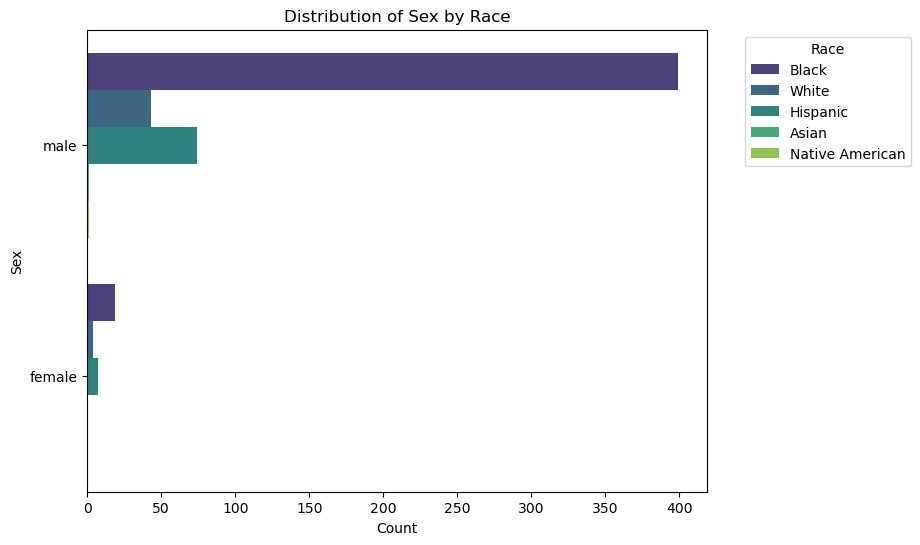

In [515]:
plt.figure(figsize=(8, 6))
sns.countplot(data=exon_df, 
              y='sex', 
              hue='race', 
              palette='viridis')
plt.title('Distribution of Sex by Race')
plt.xlabel('Count')
plt.ylabel('Sex')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()

The chart above highlights the distribution of exonerees' sex across racial groups. **Male exonerees dominate in every racial category, with Black men making up the largest share. **This reflects well-documented systemic racial disparities in the criminal justice system, where Black individuals are over-policed, over-arrested, and disproportionately wrongfully convicted. [@jones-brown_over-policing_2021]  

The counts for female exonerees are strikingly low across all racial groups, a trend that is consistent with the overall underrepresentation of women in the criminal justice system. Women are less likely to be arrested and incarcerated, which partially explains their near invisibility in exoneration data. However, it is important to note that while the overall numbers for women are small, **Black women make up a larger portion of female exonerees compared to other racial groups, demonstrating that Black women, existing at the intersection of racial and gender biases, face compounded vulnerabilities within the justice system.**

## Numerical Variables 

### Age Distribution of Exonerees

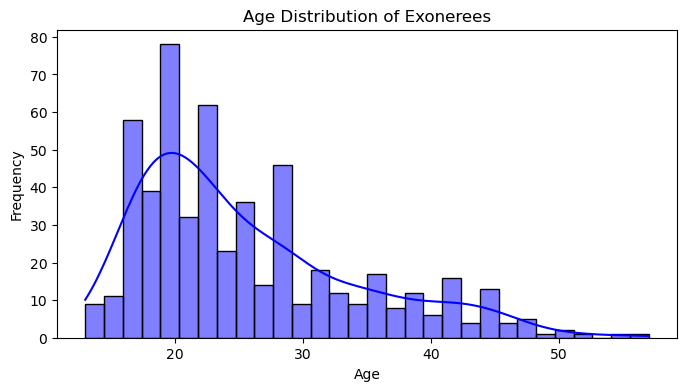

In [516]:
plt.figure(figsize=(8, 4))
sns.histplot(exon_df['age'], kde=True, bins=30, color='blue')
plt.title('Age Distribution of Exonerees')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

The age distribution of exonerees is visualized in the histogram above, which includes a kernel density estimate (KDE) to illustrate the overall shape of the data. The distribution is **right-skewed, with most exonerees concentrated in the younger age range, particularly between 20 and 30 years old**. The frequency begins to taper off as age increases, with far fewer exonerees above the age of 40.  **This skewed pattern suggests that younger individuals are disproportionately represented among Illinois’ exonerees, which may reflect broader systemic trends in arrest rates, convictions, or vulnerabilities within the justice system that disproportionately affect younger populations.** The KDE line further highlights the sharp peak in the younger age range, emphasizing the concentration of exonerees in this group.  These findings raise important questions about age-specific factors contributing to wrongful convictions, such as policing practices, access to legal resources, or biases that may disproportionately impact younger individuals. Further research could help unpack these trends and identify critical points of intervention.  

#### Age Distribution of Exonerees by Race

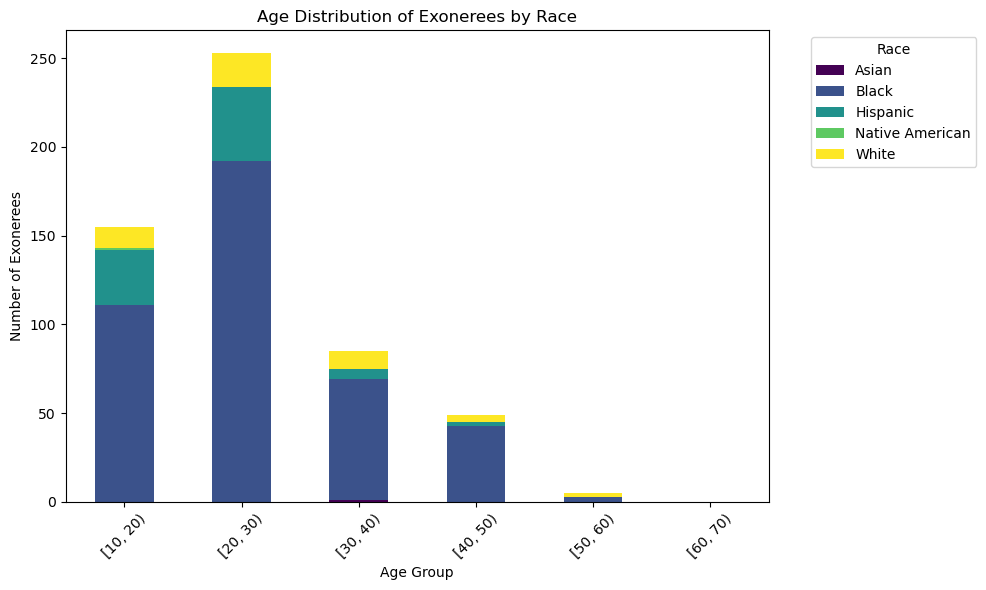

In [587]:
# Bin the ages into groups
age_bins = [10, 20, 30, 40, 50, 60, 70]  # Adjust bins as needed
exon_df['age_group'] = pd.cut(exon_df['age'], bins=age_bins, right=False)

# Group the data by age group and race
age_race_counts = exon_df.groupby(['age_group', 'race']).size().unstack(fill_value=0)
age_race_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

plt.title("Age Distribution of Exonerees by Race")
plt.xlabel("Age Group")
plt.ylabel("Number of Exonerees")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title="Race", bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()

The visualization enhances the age analysis and highlights a critical finding: young Black, in the 20-30 age group, men are disproportionately represented among exonerees, reflecting systemic failures within the criminal justice system, where young Black men face heightened vulnerability to wrongful convictions due to over-policing, racial bias, and systemic inequities.  [@jones-brown_over-policing_2021] 

### Distribution of Years Wrongfully Lost by Exonerees

Total Years Lost by Exonerees: 4625.81


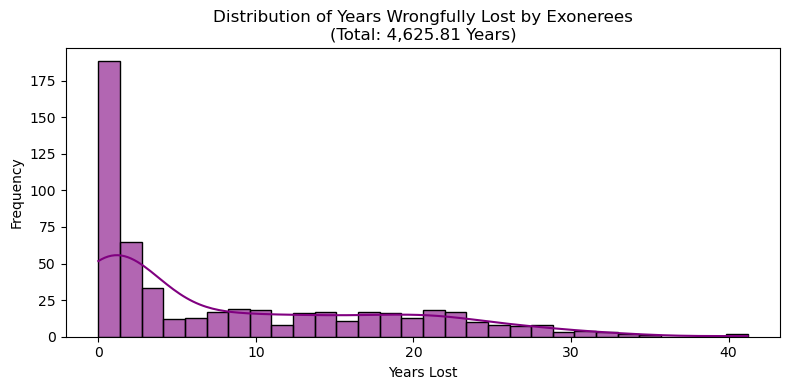

In [590]:
# Filter out invalid years_lost values (e.g., negative or null values)
exon_df_clean = exon_df[exon_df['years_lost'] >= 0]

# Calculate total years lost
total_years_lost = round(exon_df_clean['years_lost'].sum(), 2)  # Round to 2 decimal places
print(f"Total Years Lost by Exonerees: {total_years_lost}")

plt.figure(figsize=(8, 4))

sns.histplot(exon_df_clean['years_lost'], kde=True, bins=30, color='purple', alpha=0.6)

plt.title(f'Distribution of Years Wrongfully Lost by Exonerees\n(Total: {total_years_lost:,} Years)')
plt.xlabel('Years Lost')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The histogram shows the distribution of years lost by exonerees due to wrongful convictions, with a total of **4,625.81 years** lost collectively. The data is heavily skewed to the left, with most exonerees losing fewer than **5 years**, likely representing individuals who were sentenced to probation or short-term incarceration but were still wrongfully convicted. However, the presence of a long tail reveals that a significant number of individuals spent **10, 20, or even 40+ years** wrongfully imprisoned. **While these longer terms are less frequent, their profound impact cannot be overstated, representing irreparable harm where decades of freedom were unjustly taken. This visualization emphasizes both the immense collective burden and the devastating individual human cost of wrongful convictions.**

#### Distribution of Years Wrongfully Lost by Exonerees by Race

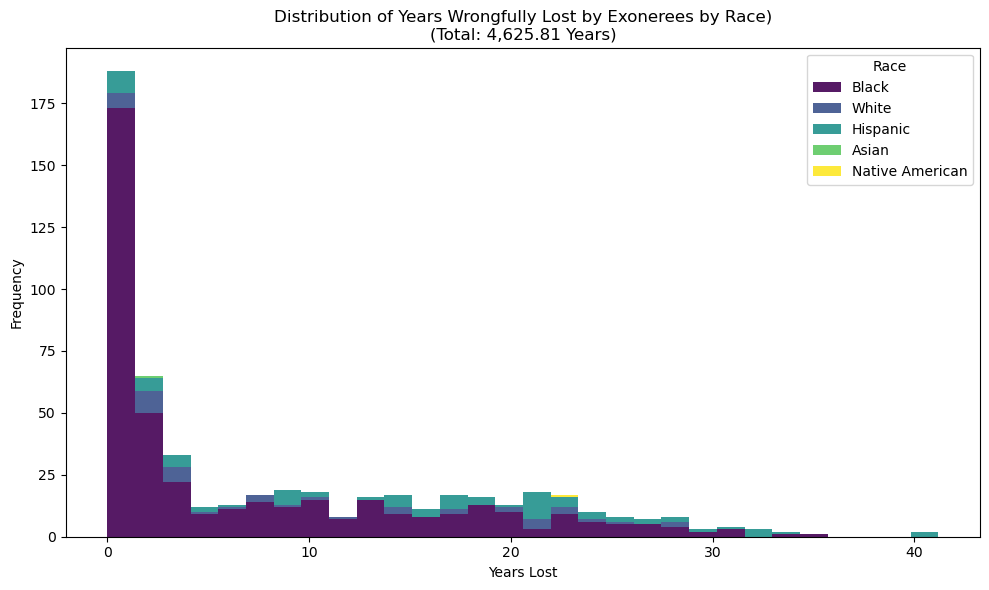

In [589]:
plt.figure(figsize=(10, 6))

races = exon_df_clean['race'].unique()
data_by_race = [exon_df_clean[exon_df_clean['race'] == race]['years_lost'] for race in races]

plt.hist(data_by_race, bins=30, stacked=True, color=plt.cm.viridis(np.linspace(0, 1, len(races))), label=races, alpha=0.9)

plt.title(f"Distribution of Years Wrongfully Lost by Exonerees by Race)\n(Total: {total_years_lost:,} Years)")
plt.xlabel("Years Lost")
plt.ylabel("Frequency")
plt.legend(title="Race", loc='upper right')  # Add a legend for clarity
plt.tight_layout()
plt.show()

The visualization underscores a critical disparity: Black individuals account for the vast majority of years wrongfully lost, reflecting systemic failures that disproportionately target Black communities. This burden extends far beyond individual exonerees—decades of stolen freedom amplify generational harm, perpetuating cycles of instability and deepening systemic inequities within the criminal justice system.

## Implications
The univariate analysis highlights deeply entrenched systemic disparities within wrongful convictions across **race, gender, and age**. Black individuals account for the overwhelming majority of exonerees, underscoring racialized patterns of disproportionate targeting within the criminal justice system. Hispanic individuals follow, particularly in drug-related cases, while White individuals remain underrepresented.   While gender disparities in exonerations reflect broader trends of men being overrepresented in the justice system, the disproportionate presence of Black women among female exonerees reveals a unique intersection of biases. Women are often perceived as less likely to commit crimes due to societal stereotypes that frame them as less harmful or less threatening, which partially explains their overall underrepresentation. However, this perception does not shield Black women from racial biases, which place them at a heightened risk of wrongful conviction relative to their female counterparts. The result is a compounded vulnerability: while women as a whole are underrepresented among Illinois exonerees, Black women remain disproportionately overrepresented within this subset, illustrating how overlapping racial and gender biases converge to uniquely impact women of color.  

Age-specific patterns reveal that younger individuals, mainly those aged 20 to 30, are disproportionately represented among exonerees. **However, the data makes clear that this is not just an issue of age—young Black men are overwhelmingly central to this trend.** The analysis of **years lost** further underscores the devastating consequences, with many exonerees losing fewer than 5 years but some enduring **10, 20, or even 40+ years** of unjust imprisonment. This disproportionate targeting of young Black men reflects a justice system that fails at every level, perpetuating racialized harm that fractures lives, families, and entire communities.  

# Bivariate Analysis

## Worst Crime Display by Race

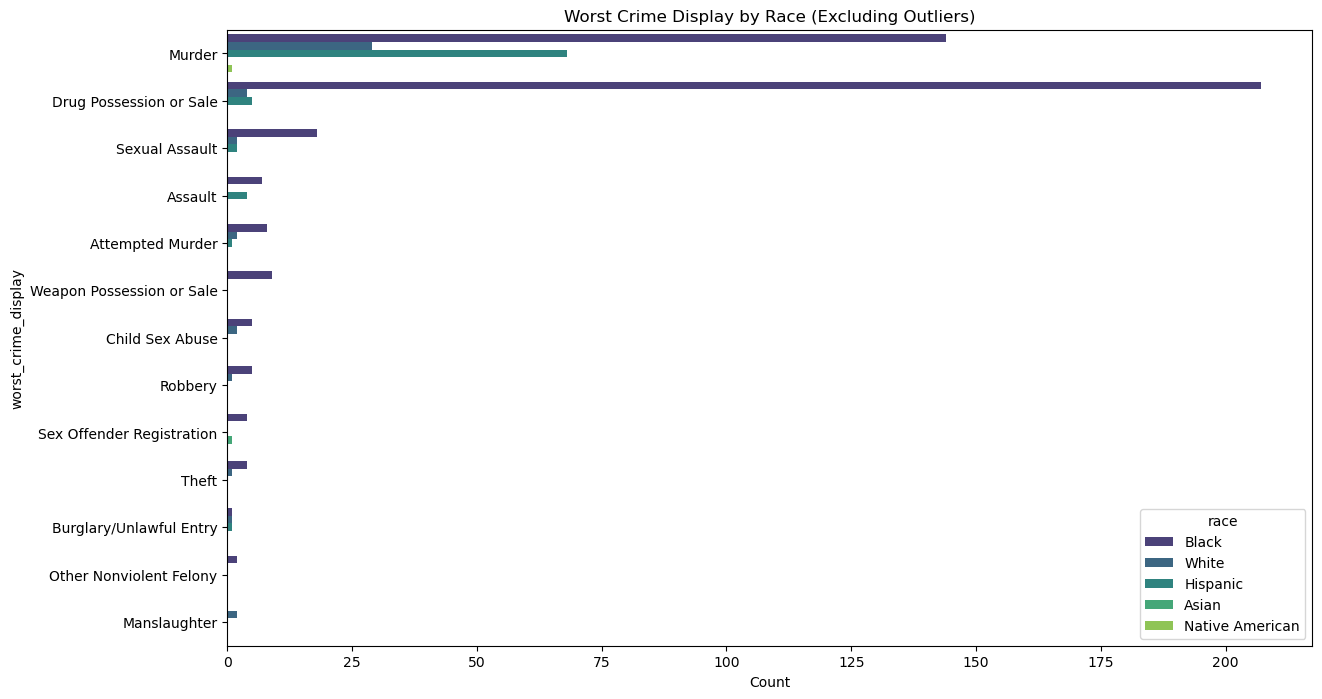

In [541]:
plt.figure(figsize=(14, 8))  # Increase figure size for better readability

# Subset the dataframe for most frequent worst crime displays, excluding outliers
subset_crimes = exon_df['worst_crime_display'].isin([
    'Murder', 'Drug Possession or Sale', 'Sexual Assault',
    'Assault', 'Attempted Murder', 'Weapon Possession or Sale',
    'Child Sex Abuse', 'Robbery', 'Theft', 'Sex Offender Registration',
    'Burglary/Unlawful Entry', 'Other Nonviolent Felony', 'Manslaughter'
])
exon_df_subset = exon_df[subset_crimes]

sns.countplot(
    data=exon_df_subset,
    y='Worst Crime Display',
    hue='race',
    order=exon_df_subset['worst_crime_display'].value_counts().index, 
    palette='viridis',
    linewidth=0.5 
)

plt.title('Worst Crime Display by Race (Excluding Outliers)')
plt.xlabel('Count')
plt.show()


The bar chart underscores wrongful conviction data categorized by race and the most serious crimes committed. **Murder and Drug Possession or Sale dominate as the leading causes of wrongful convictions, with Black individuals disproportionately represented in these categories.** Black individuals face significantly higher rates of wrongful convictions compared to other racial groups, with Hispanic individuals following closely—predominately in cases involving drug-related charges. In contrast, wrongful convictions among White individuals appear less frequent for these crimes. While wrongful convictions for nonviolent offenses like theft or burglary are relatively rare across racial groups, the overrepresentation of Black and Hispanic individuals in the most severe crime categories is indicative of pervasive biases embedded within judicial processes. 

## Exoneree Sentence Length by Race

Rows where `sentence_in_years` equaled 100 were excluded from the analysis to account for life sentences and death penalties, which had been coded as "100 years" during data cleaning. Including these extreme values likely would have skewed the distribution and created misleading interpretations of the results. By removing these outliers, the analysis focuses on **finite sentence lengths**, offering a clearer and more accurate representation of sentencing disparities among exonerees across racial groups. 

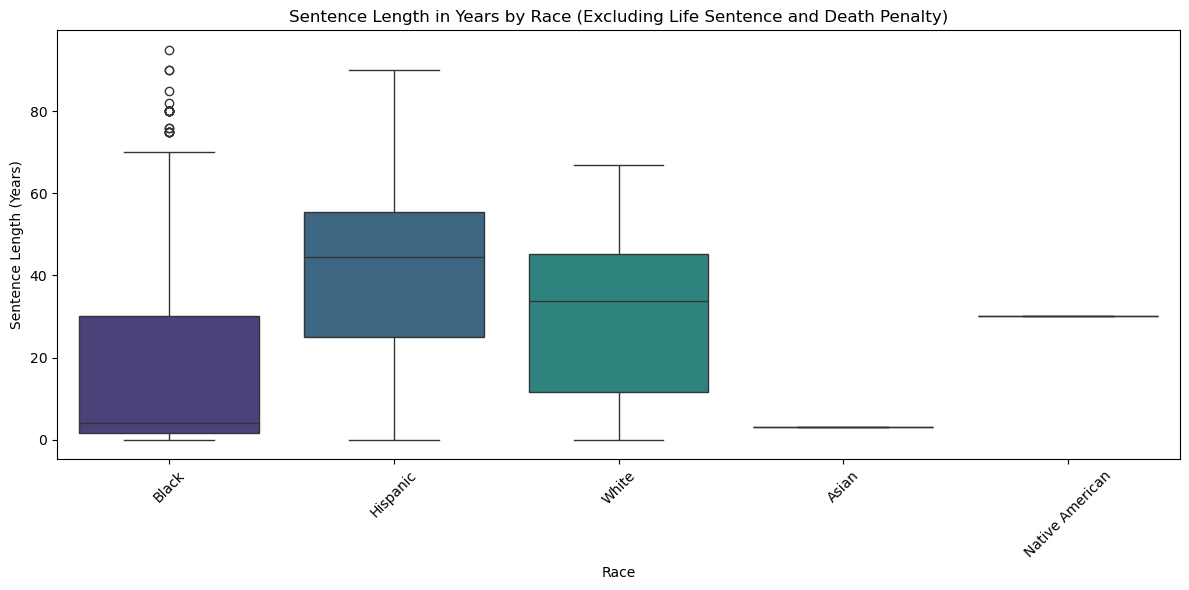

In [551]:
# Drop rows where sentence_in_years equals 100 -> life sentence and death penalty
df_filtered = exon_df[exon_df['sentence_in_years'] != 100]

# Plot Sentence in Years by Race
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='race', y='sentence_in_years', palette='viridis')
plt.title('Sentence Length in Years by Race (Excluding Life Sentence and Death Penalty)')
plt.xlabel('Race')
plt.ylabel('Sentence Length (Years)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The boxplot highlights critical disparities in sentence lengths for exonerees across racial categories where Black individuals show shorter median sentence lengths overall, yet their data contains a significant number of outliers, indicating that some individuals served exceptionally long sentences. Hispanic individuals display the widest range in sentence lengths, with many values extending toward the higher end. White individuals follow a similar pattern but exhibit a slightly lower spread compared to Hispanic individuals. For Asian and Native American groups, the limited number of observations makes it difficult to identify definitive trends. These findings emphasize that racial disparities in wrongful convictions extend beyond the conviction itself, revealing inconsistencies in the length of sentences served prior to exoneration.  

### Normalized Sentence Length in Years by Race
The following boxplot applies **Z-score normalization** to sentence lengths, adjusting values within each racial group to have a mean of zero and a standard deviation of one. This transformation ensures that sentence lengths are evaluated relative to their group’s internal distribution, eliminating distortions caused by variations in scale or sample size.


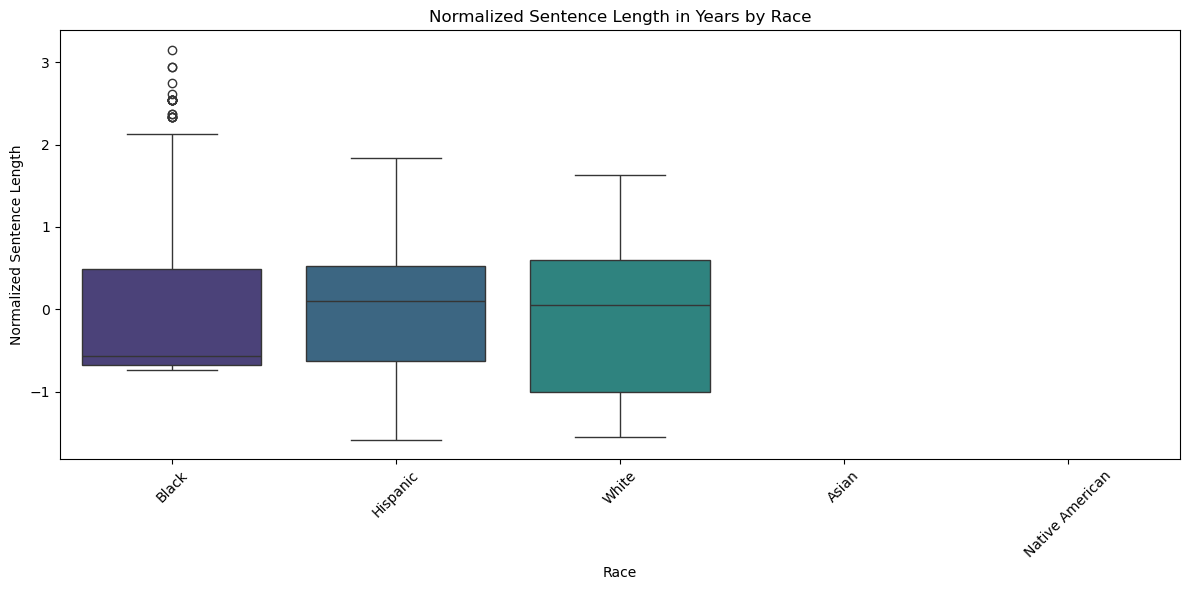

In [550]:
# Calculate sample size per race
race_counts = df_filtered['race'].value_counts()

#   Z-Score normalization
df_filtered['normalized_sentence_length'] = (
    df_filtered.groupby('race')['sentence_in_years']
    .transform(lambda x: (x - x.mean()) / x.std())
)

# Plot the normalized sentence lengths
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='race', y='normalized_sentence_length', palette='viridis')
plt.title('Normalized Sentence Length in Years by Race')
plt.xlabel('Race')
plt.ylabel('Normalized Sentence Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The boxplot reveals persistent disparities across racial groups even after normalization. Black individuals exhibit a concentration of outliers at the higher end, reflecting extreme sentence lengths relative to their group average. Hispanic and White individuals show a similar spread, with Hispanic individuals slightly skewed toward higher values. Asian and Native American groups lack sufficient data for definitive interpretation, as their categories show minimal or no variance. While normalization adjusts for group-level differences, the persistence of extreme values among Black individuals highlights systemic sentencing inequities that cannot be erased through statistical transformation alone.

### Implications  

The bivariate analysis highlights systemic racial disparities in wrongful convictions, particularly for Black and Hispanic individuals. Black exonerees are disproportionately represented in severe crime categories like **murder** and **drug-related offenses**, reflecting the long-standing impact of **over-policing** and biased law enforcement practices. Hispanic individuals also face elevated wrongful convictions in drug-related crimes, while White individuals are underrepresented across these categories. Sentencing disparities further deepen these inequities. Black individuals experience extreme outliers in sentence lengths, with many serving exceptionally long terms before exoneration. Hispanic exonerees show the broadest range in sentence lengths, pointing to inconsistencies in sentencing practices that disproportionately impact minority groups. Even after **normalization**, Black individuals continue to exhibit extreme sentence values relative to their group averages, underscoring that systemic biases persist despite statistical adjustments. These findings reveal a troubling pattern of racialized injustice within the criminal legal system. From arrest to conviction to sentencing, Black and Hispanic individuals face disproportionate harm, driven by structural biases that demand urgent reform.  


# Geographic Analysis

### Libraries and Tools  
To conduct the geospatial analysis, the following libraries were essential:  

- **Fiona**: For reading and writing GIS vector files.  
- **Shapely.geometry**: To create and manipulate geometric objects, such as points for latitude/longitude coordinates.  
- **GeoPandas**: An extension of pandas that integrates geographic data, allowing spatial operations like mapping and merging shapefiles.  

These tools provided the functionality to load, preprocess, and visualize geographic data effectively.

In [508]:
# Import necessary Libraries
from shapely.geometry import Point  # Used for creating and analyzing geometric objects.
import geopandas as gpd  # Extension of pandas used for working with geospatial data
import fiona  # Used for reading and writing GIS vector files

# Load cleaned exoneration dataset
exon_df = pd.read_csv('../../data/processed-data/illinois_exoneration_data.csv')
#exon_df.head()

## Geospatial Workflow
The following analyses involved a sequence of steps to prepare and visualize the exoneration and arrest data:  

### Geometry Creation
Using `shapely.geometry`, latitude and longitude values were converted into geometric points to map exoneration cases spatially. This allowed for the dataset to be transformed into a GeoDataFrame using **GeoPandas**.  


In [475]:
# Create geometry column for points based on latitude and longitude
geometry = [Point(xy) for xy in zip(exon_df['longitude'], exon_df['latitude'])]
geo_df = gpd.GeoDataFrame(exon_df, geometry=geometry)

### Loading Shapefiles
 The Illinois county boundary shapefile was loaded using **GeoPandas** (`gpd.read_file`). This file provided the geographic outlines needed to visualize data at the county level.  

In [476]:
# Load Illinois county shapefile 
illinois_counties = gpd.read_file('../../data/geospatial/IL_BNDY_COUNTY_Py.shp')

### Aggregating Exoneration Data 
Exoneration counts were grouped by county and race to produce a summarized table of exonerations (`groupby` in pandas). This data was then merged with the Illinois shapefile to align geographic boundaries with exoneration counts.  

In [477]:
# Aggregate exoneration counts by county and race
exoneration_counts = exon_df.groupby(['county', 'race'], as_index=False).size()
exoneration_counts.rename(columns={'size': 'num_exonerations'}, inplace=True)

illinois_counties['county'] = illinois_counties['COUNTY_NAM'].str.title()  # Match casing

# Merge exoneration data with shapefile
merged_counties = illinois_counties.merge(exoneration_counts, on='county', how='left')


### Aggregating Arrest Data 
Arrest counts were grouped by county and race to produce a summarized table of arrests (`groupby` in pandas). This data was then merged with the Illinois shapefile to align geographic boundaries with arrest totals.  

In [478]:
# Load aggregated arrests data
aggregated_data = pd.read_csv('../../data/processed-data/aggregated_arrests_2001_to_2021.csv')
aggregated_data_melted = aggregated_data.melt(id_vars='race', var_name='county', value_name='total_arrests')

# Aggregate total arrests by county for all races
total_arrests_by_county = aggregated_data_melted.groupby('county')['total_arrests'].sum().reset_index()

# Ensure county names are consistent
total_arrests_by_county['county'] = total_arrests_by_county['county'].str.strip().str.title()

# Merge total arrests data with the shapefile
merged_total_arrests = illinois_counties.merge(total_arrests_by_county, on='county', how='left')

### Handling Missing Data
Counties without recorded exonerations or arrests were assigned a count of `0` to ensure completeness in the visualizations.  


In [479]:
# Replace NaN values with 0 for counties without exonerations
merged_counties['num_exonerations'] = merged_counties['num_exonerations'].fillna(0)

# Fill NaN values with 0 for counties without data
merged_total_arrests['total_arrests'] = merged_total_arrests['total_arrests'].fillna(0)


### Logarithmic Transformation
The geospatial analysis visualizes exoneration and arrest patterns across Illinois counties. Cook County’s numbers are **orders of magnitude higher** than those in other counties, which skews the results and makes it difficult to identify trends in smaller counties on a linear scale. To address this, two scaling approaches were used:  

-  **Logarithmic Scaling (Including Cook County)**: Log transformations (`np.log1p`) compress the data range, making patterns in smaller counties clearer while still preserving Cook County’s contribution.  
-  **Linear Scaling (Excluding Cook County)**: Removing Cook County allows linear scaling to highlight smaller variations across the remaining counties, ensuring their natural distribution is preserved.  

With log scaling, patterns across smaller counties become visible without Cook County completely dominating the visualization. Even on a linear scale, exonerations and arrests remain heavily concentrated in **urban areas** like Cook County and its surrounding regions.  

This dual approach highlights the systemic concentration of wrongful convictions and arrests in high-population areas while ensuring patterns in smaller counties are not obscured. By combining log scaling and linear scaling, the visualizations strike a balance between emphasizing Cook County’s impact and uncovering broader geographic trends.  

In [480]:
# Exonerations Log transformation to handle the exponential scale of Cook County data
merged_counties['log_num_exonerations'] = np.log1p(merged_counties['num_exonerations'])

# Arrests Log transformation to handle the exponential scale of Cook County data
merged_total_arrests['log_total_arrests'] = np.log10(merged_total_arrests['total_arrests'] + 1)  # Add 1 to avoid log(0)

# Filter out Cook County 
filtered_counties = merged_counties[merged_counties['county'] != 'Cook']
filtered_total_arrests = merged_total_arrests[merged_total_arrests['county'] != 'Cook']


## Exonerations by County


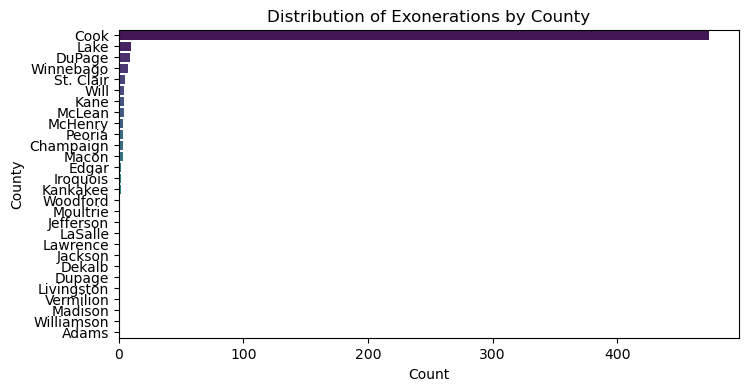

In [481]:
plt.figure(figsize=(8, 4))
sns.countplot(y=exon_df['county'], order=exon_df['county'].value_counts().index, palette='viridis')
plt.title('Distribution of Exonerations by County')
plt.xlabel('Count')
plt.ylabel('County')
plt.show()


::: note
For context, Chicago is located within Cook County.
:::

### Log-Scaled Number of Exonerations by County in Illinois

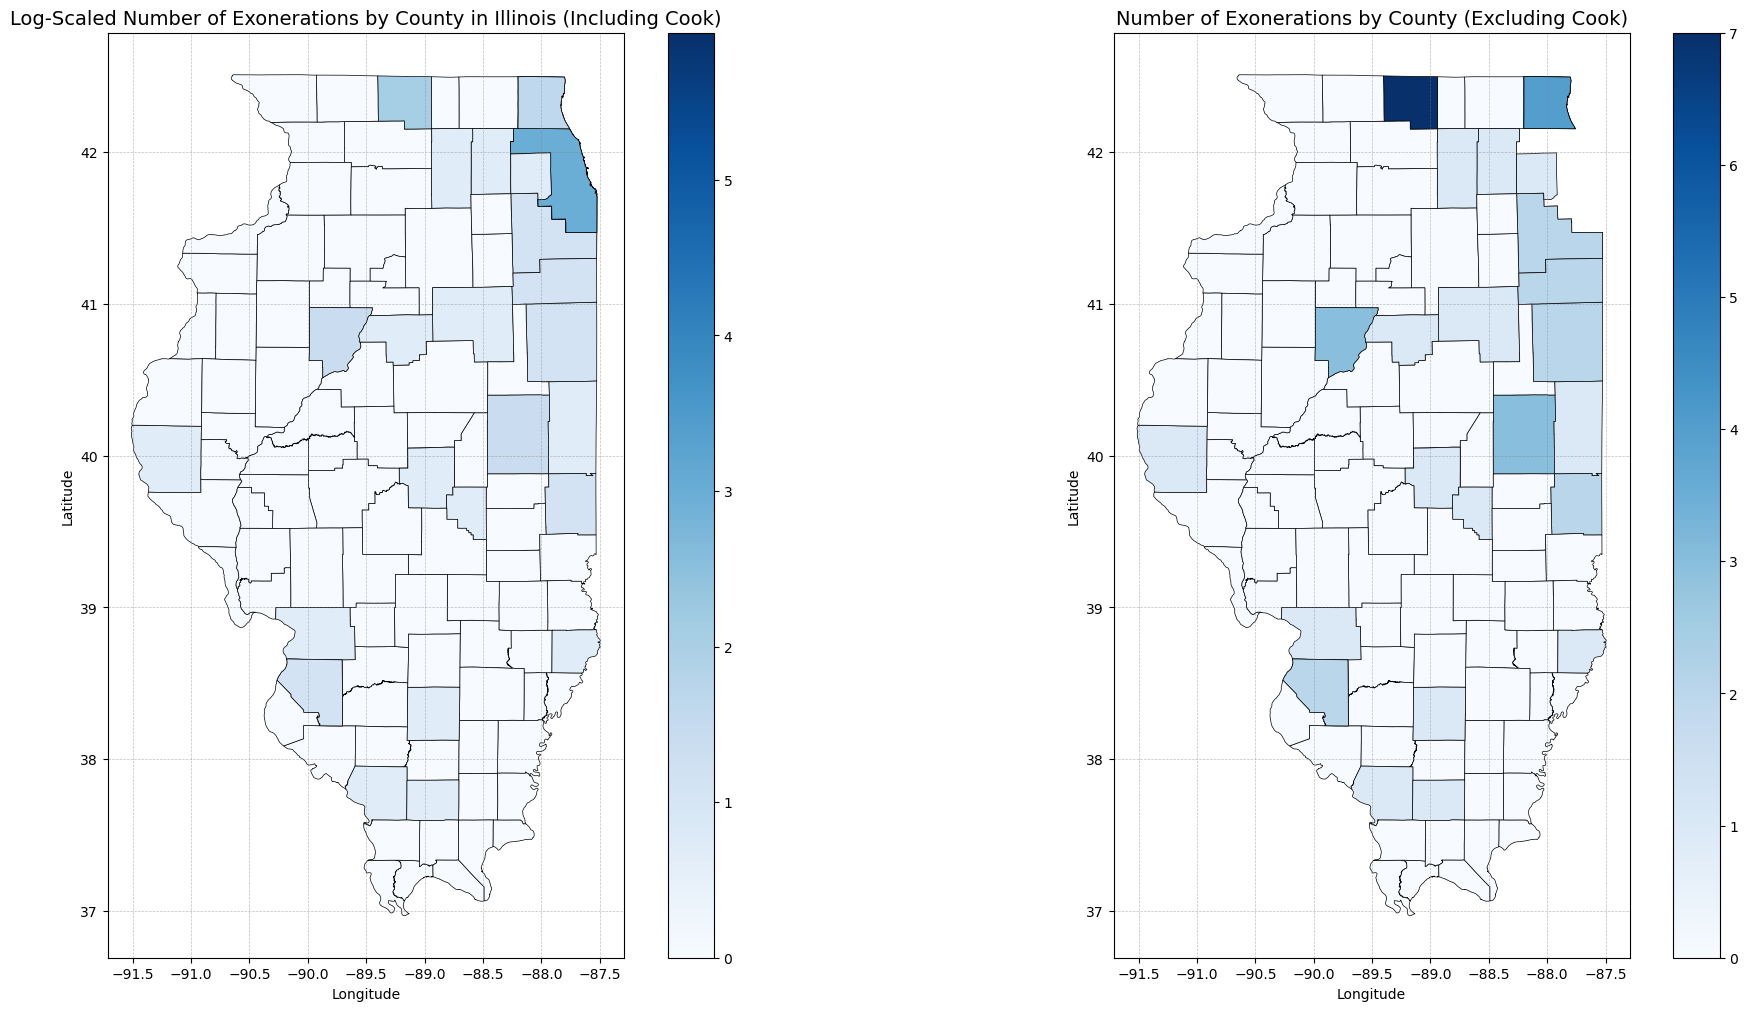

In [482]:
# Creates side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

merged_counties.plot(
    column='log_num_exonerations',  # Use the log-transformed column
    cmap='Blues',
    linewidth=0.5,
    edgecolor='black',
    ax=axes[0],
    legend=True
)
axes[0].set_title("Log-Scaled Number of Exonerations by County in Illinois (Including Cook)", fontsize=14)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot the gradient map excluding Cook County, keeping linear scale
filtered_counties.plot(
    column='num_exonerations',  
    cmap='Blues',
    linewidth=0.5,
    edgecolor='black',
    ax=axes[1],
    legend=True
)
axes[1].set_title("Number of Exonerations by County (Excluding Cook)", fontsize=14)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

The maps reveal critical patterns in both exonerations and arrests across Illinois counties. Cook County (Chicago), as expected, dominates the data with **orders of magnitude higher counts**, which skews the results and makes it challenging to identify trends in smaller counties. To address this, a **logarithmic transformation** (`np.log1p`) was applied to compress the data range, ensuring that smaller counties remain visible without flattening Cook County's impact. When Cook County is excluded, **linear scaling** highlights natural variations across the remaining counties. While smaller differences become more interpretable, the visualizations still emphasize the concentration of arrests and exonerations in urban regions outside Cook County. This dual scaling approach—logarithmic for overall visibility and linear for regional comparisons—strikes a balance, allowing geographic disparities across Illinois to emerge clearly.  By visualizing both exonerations and arrests, the maps underscore systemic trends: wrongful convictions are disproportionately concentrated in high-population areas, particularly urban hubs. At the same time, significant activity persists in smaller counties, reinforcing the need for statewide examination of these issues.  

## Arrests by County

### Log-Scaled Total Arrests by County in Illinois 

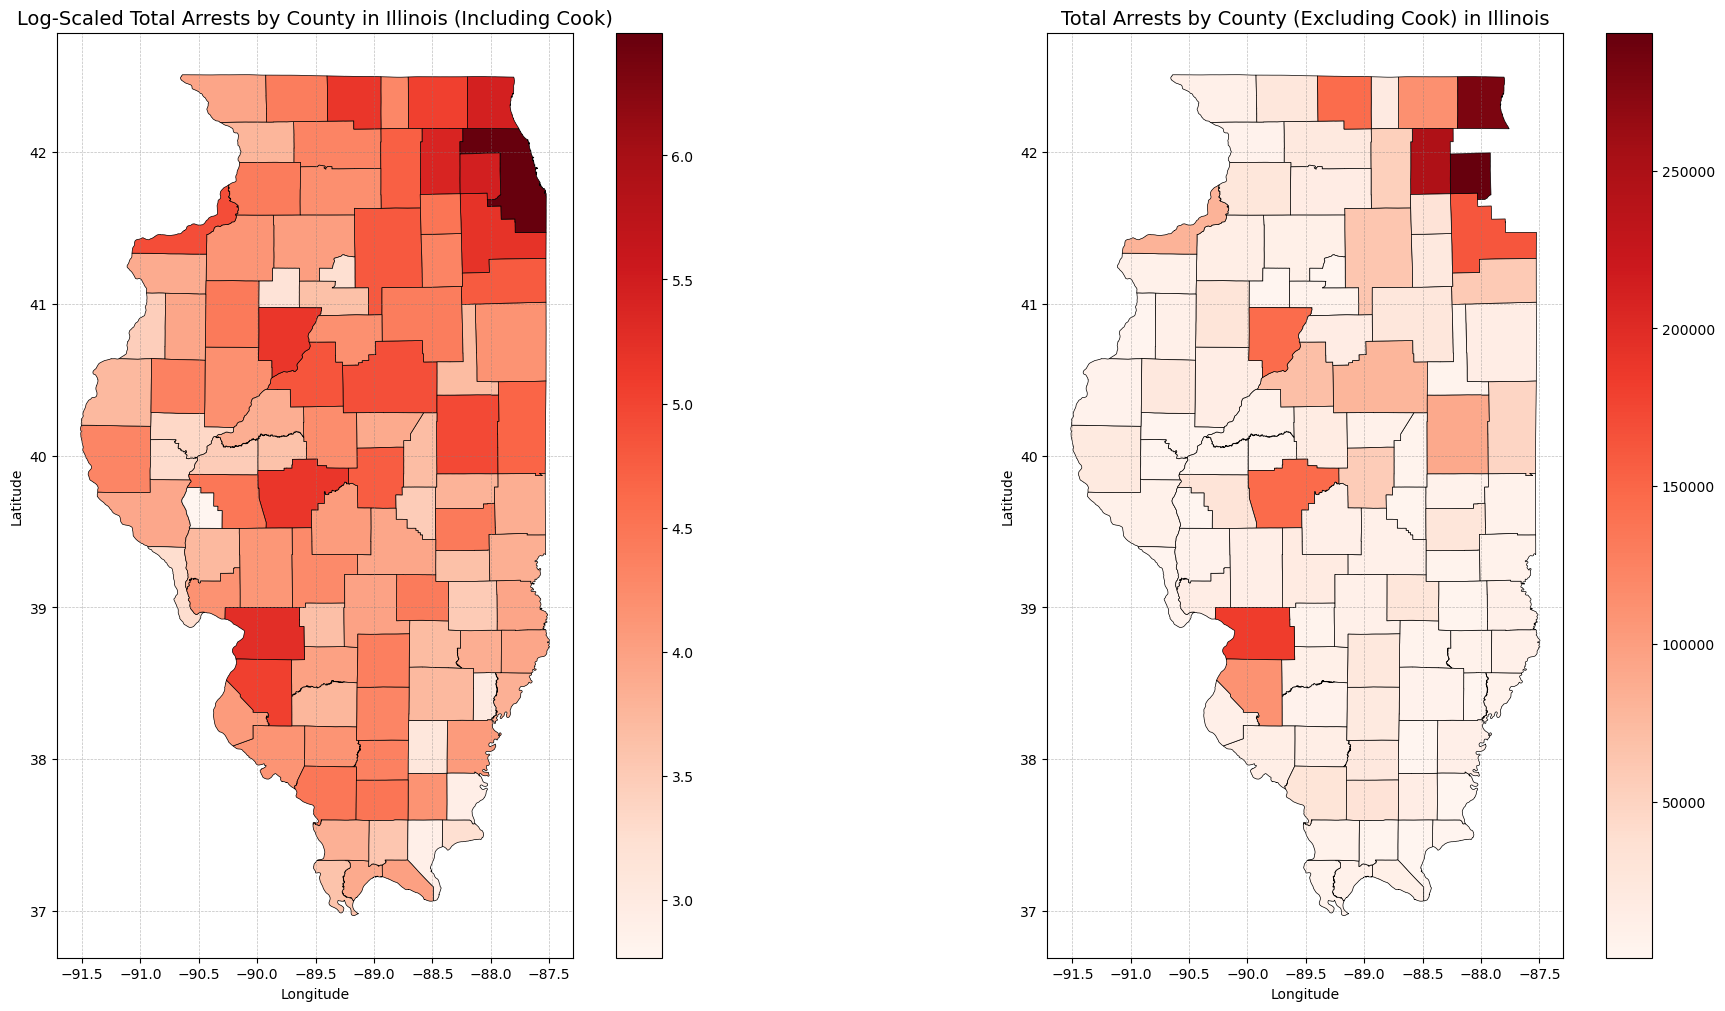

In [483]:
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

# Plot the gradient map for total arrests by county (including Cook County with log scale)
merged_total_arrests.plot(
    column='log_total_arrests',  # Use log-scaled data
    cmap='Reds',
    linewidth=0.5,
    edgecolor='black',
    ax=axes[0],
    legend=True
)
axes[0].set_title("Log-Scaled Total Arrests by County in Illinois (Including Cook)", fontsize=14)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot the gradient map for total arrests by county (excluding Cook County with linear scale)
filtered_total_arrests.plot(
    column='total_arrests',  # Use linear-scaled data
    cmap='Reds',
    linewidth=0.5,
    edgecolor='black',
    ax=axes[1],
    legend=True
)
axes[1].set_title("Total Arrests by County (Excluding Cook) in Illinois", fontsize=14)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Show the side-by-side maps
plt.show()

The maps highlight clear geographic disparities in arrest patterns across Illinois. Urban counties, particularly Cook County, dominate the arrest totals, even when using a logarithmic scale to compress the data. Cook County remains a significant outlier, with arrest counts orders of magnitude higher than in rural areas, driving the statewide totals. When Cook County is excluded and linear scaling is applied, the smaller counties' arrest patterns become more visible. While some rural counties show modest variations, their arrest totals remain consistently lower than those in urban regions.To provide further context, Illinois counties' rural and urban classifications **(see Appendix A)** align with these trends. Rural counties—defined by lower population densities—consistently exhibit fewer arrests, while urban counties, like Cook, DuPage, and Lake, demonstrate the systemic concentration of policing and arrests in high-population areas.

## Total Arrests by Race and County
### Log-Scaled Total Arrests by Race and County

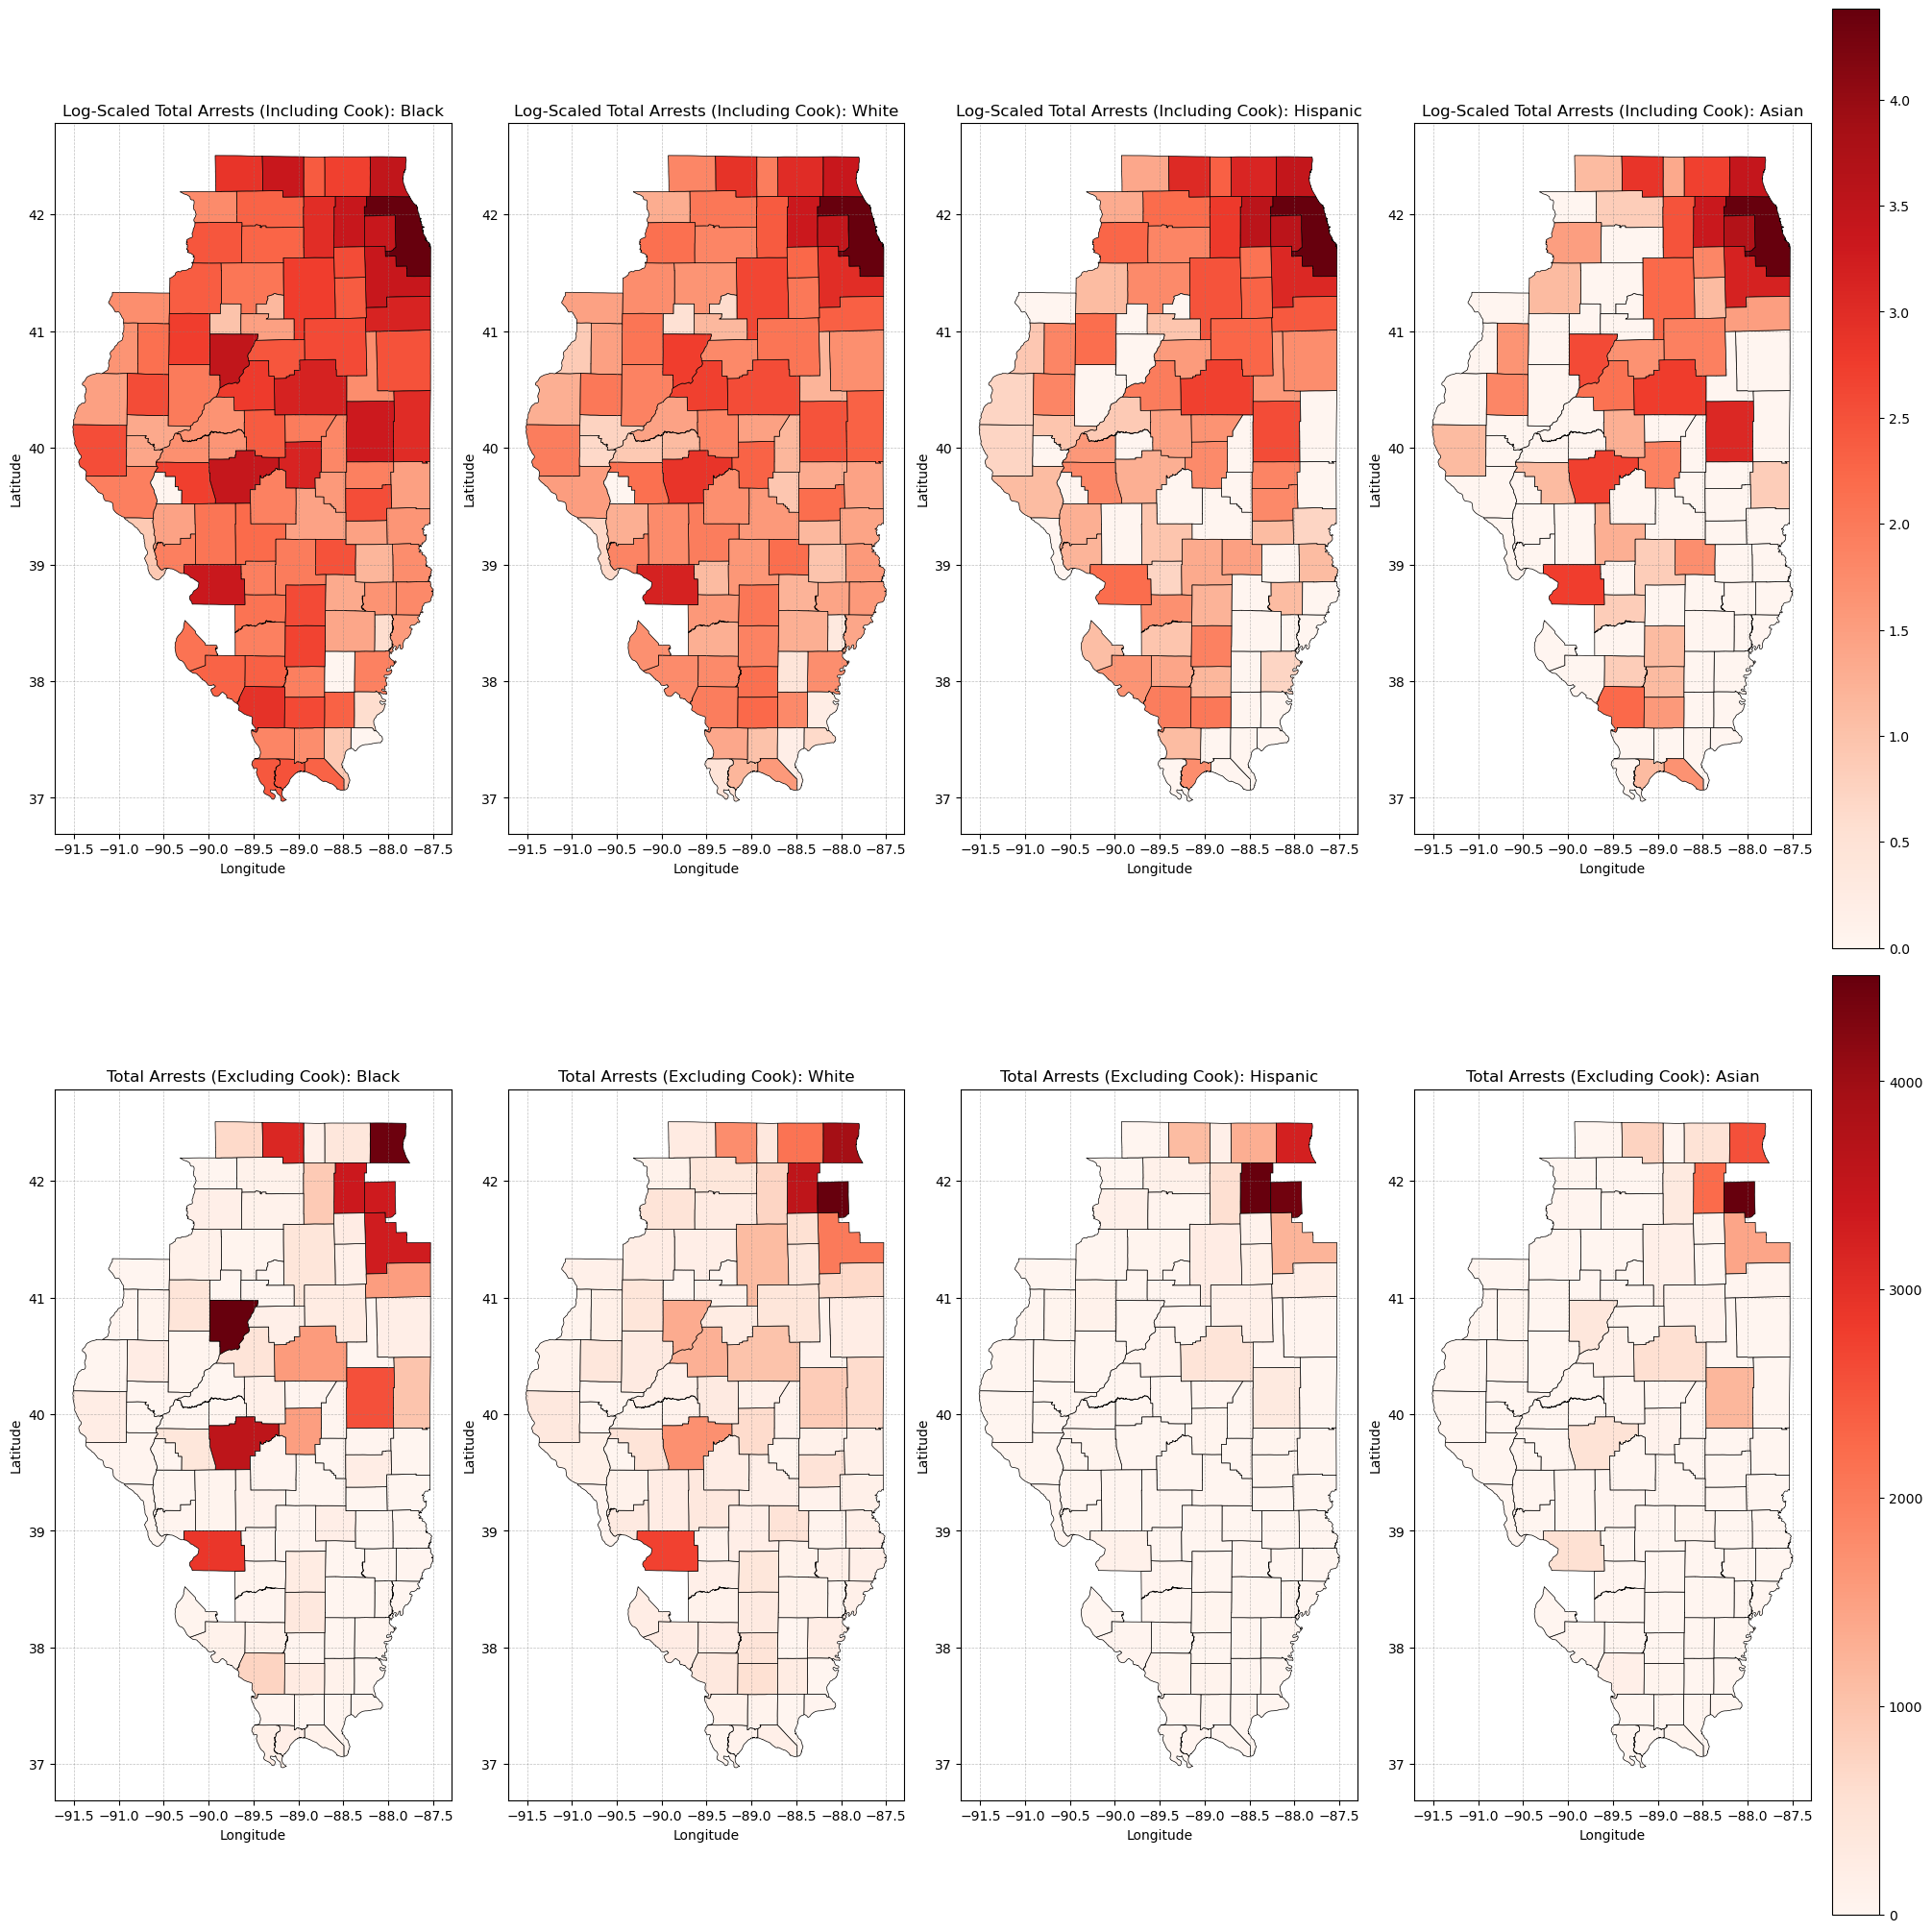

In [484]:
merged_total_arrests = illinois_counties.merge(
    aggregated_data_melted, on='county', how='left'
)

merged_total_arrests['total_arrests'] = merged_total_arrests['total_arrests'].fillna(0)

# Log-transform total arrests for maps including Cook County
merged_total_arrests['log_total_arrests'] = np.log10(merged_total_arrests['total_arrests'] + 1)  # Add 1 to avoid log(0)

# Filter out Cook County
merged_data_excluding_cook = merged_total_arrests[merged_total_arrests['county'] != 'Cook']

# Define the races to plot
races_to_plot = ["Black", "White", "Hispanic", "Asian"]

# Create subplots
fig, axes = plt.subplots(2, len(races_to_plot), figsize=(20, 20), constrained_layout=True)

# Plot each race's data (including Cook County with log scale) on the first row
for i, race in enumerate(races_to_plot):
    race_data = merged_total_arrests[merged_total_arrests['race'] == race]

    # Ensure data is not empty
    if race_data.empty:
        print(f"No data available for the selected race: {race}")
        continue

    # Plot the gradient map for the current race
    race_data.plot(
        column='log_total_arrests',  # Use log-transformed data
        cmap='Reds',
        linewidth=0.5,
        edgecolor='black',
        ax=axes[0, i],
        legend=(i == len(races_to_plot) - 1)  # Show legend only on the last subplot
    )
    axes[0, i].set_title(f"Log-Scaled Total Arrests (Including Cook): {race}")
    axes[0, i].set_xlabel("Longitude")
    axes[0, i].set_ylabel("Latitude")
    axes[0, i].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot each race's data (excluding Cook County with linear scale) on the second row
for i, race in enumerate(races_to_plot):
    race_data = merged_data_excluding_cook[merged_data_excluding_cook['race'] == race]

    # Ensure data is not empty
    if race_data.empty:
        print(f"No data available for the selected race: {race}")
        continue

    # Plot the gradient map for the current race
    race_data.plot(
        column='total_arrests',  # Use linear scale for excluding Cook
        cmap='Reds',
        linewidth=0.5,
        edgecolor='black',
        ax=axes[1, i],
        legend=(i == len(races_to_plot) - 1)  # Show legend only on the last subplot
    )
    axes[1, i].set_title(f"Total Arrests (Excluding Cook): {race}")
    axes[1, i].set_xlabel("Longitude")
    axes[1, i].set_ylabel("Latitude")
    axes[1, i].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Show the plot
plt.show()

### Hypothesis Testing 

#### Kruskal-Wallis
The **Kruskal-Wallis Test** was applied to assess whether significant differences exist in total arrests across racial groups—specifically Black, White, and Hispanic populations. This statistical method was chosen due to its suitability for the data and the research question at hand:

- As a **non-parametric test**, it bypasses the requirement for data to adhere to a normal distribution.  
- It is effective for comparing **three or more independent groups**, making it ideal for this analysis of racial categories.  
- The test assumes that the groups being compared are **independent** of one another.  
- By evaluating **medians** and ranking data, it demonstrates resilience against the influence of outliers and skewed distributions.

**Null Hypothesis (H₀):** There is no significant difference in total arrests across racial groups.

**Alternative Hypothesis (H₁):** There is a significant difference in total arrests across racial groups.

In [485]:
from scipy.stats import kruskal

# Group total arrests by race
black_arrests = merged_total_arrests[merged_total_arrests['race'] == 'Black']['total_arrests']
white_arrests = merged_total_arrests[merged_total_arrests['race'] == 'White']['total_arrests']
hispanic_arrests = merged_total_arrests[merged_total_arrests['race'] == 'Hispanic']['total_arrests']

# Kruskal-Wallis Test
h_stat, p_val = kruskal(black_arrests, white_arrests, hispanic_arrests)
print(f"Kruskal-Wallis Test: H-statistic = {h_stat:.4f}, p-value = {p_val:.4f}")


Kruskal-Wallis Test: H-statistic = 161.1528, p-value = 0.0000


Given the p-value of **0.0000**, which is well below the conventional threshold of 0.05, the results indicate **statistically significant differences** in total arrests between the racial groups. In other words, the distribution of total arrests is not equal across the Black, White, and Hispanic categories. This finding underscores the presence of disparities in arrest rates among these racial groups, warranting further investigation to explore underlying causes, systemic factors, or policy implications contributing to these observed differences.

#### ANOVA Permutation Test  

To complement the Kruskal-Wallis test, an **ANOVA Permutation Test** was performed to assess whether there are significant differences in total arrests across racial groups (e.g., Black, White, and Hispanic). Unlike the Wallis test, which is a non-parametric test, ANOVA compares the **means** of the groups and assumes normally distributed data with stable variance. 
The **ANOVA Permutation Test** is robust and does not rely on strict assumptions of normality. By resampling the data (permutations), it provides a valid test for group differences even when the data has been log-transformed.

**Null Hypothesis (H₀):** There is no significant difference in total arrests across racial groups (Black, White, and Hispanic).  

**Alternative Hypothesis (H₁):** There is a significant difference in total arrests across racial groups (Black, White, and Hispanic).  

##### Visualizing the Skewed Data

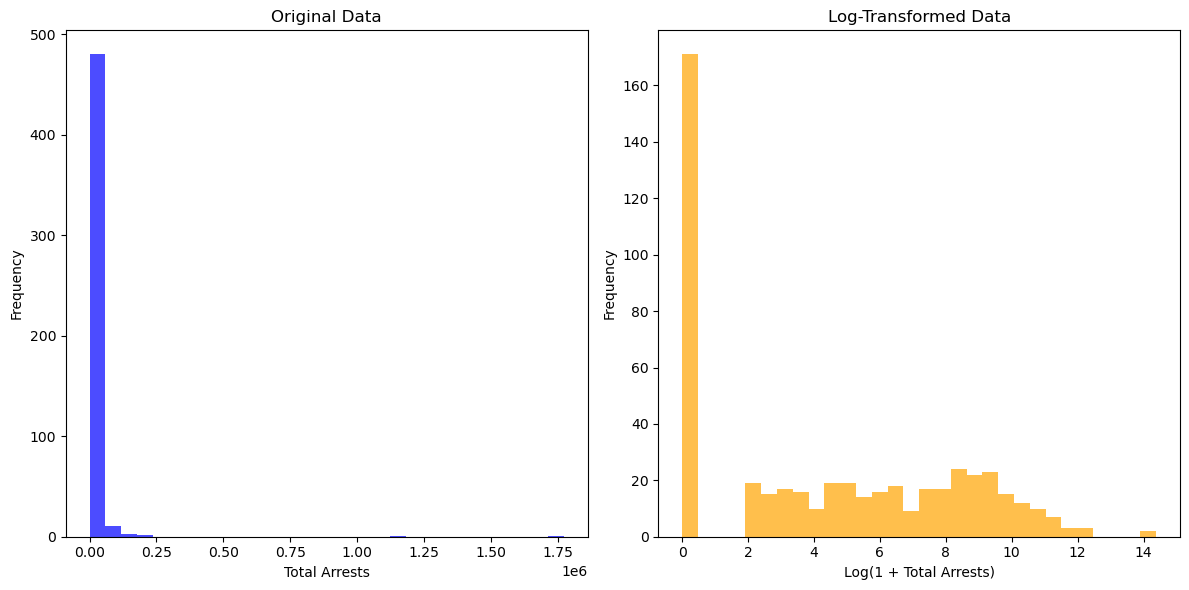

In [486]:
# Original and log-transformed data
original_data = merged_total_arrests['total_arrests']
log_transformed_data = np.log1p(merged_total_arrests['total_arrests'])

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot Original Data
ax[0].hist(original_data, bins=30, color='blue', alpha=0.7)
ax[0].set_title("Original Data")
ax[0].set_xlabel("Total Arrests")
ax[0].set_ylabel("Frequency")

# Plot Log-Transformed Data
ax[1].hist(log_transformed_data, bins=30, color='orange', alpha=0.7)
ax[1].set_title("Log-Transformed Data")
ax[1].set_xlabel("Log(1 + Total Arrests)")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

**Why Log Scaling Was Necessary**:  
- The original data for total arrests was **highly skewed**, with extreme values (e.g., Cook County arrests) dominating the distribution.  
- Log transformation reduces this skewness, stabilizes variance, and makes the data closer to a **normal distribution**.  
- For ANOVA, the assumptions of normality and homogeneity of variance are critical. Log transformation ensures these assumptions are better met, improving the reliability of the test results.

In contrast, the **Kruskal-Wallis test** does not require normality or equal variance since it is non-parametric and works with **ranks** instead of raw values. This makes log scaling unnecessary for Kruskal-Wallis.

In [487]:
import numpy as np
from scipy.stats import permutation_test

# Group data
groups = [
    merged_total_arrests[merged_total_arrests['race'] == 'Black']['log_total_arrests'],
    merged_total_arrests[merged_total_arrests['race'] == 'White']['log_total_arrests'],
    merged_total_arrests[merged_total_arrests['race'] == 'Hispanic']['log_total_arrests']
]

# Function to calculate F-statistic
def f_statistic(*args):
    group_means = [np.mean(g) for g in args]
    grand_mean = np.mean([x for g in args for x in g])
    ss_between = sum(len(g) * (m - grand_mean)**2 for g, m in zip(args, group_means))
    ss_within = sum(sum((x - m)**2 for x in g) for g, m in zip(args, group_means))
    return ss_between / ss_within

# Perform permutation test
result = permutation_test(groups, f_statistic, n_resamples=9999, alternative='two-sided')
print(f"Permutation-Based ANOVA: p-value = {result.pvalue:.4f}")


Permutation-Based ANOVA: p-value = 0.0002


The p-value (0.0002) is **far below the significance threshold** of 0.05. This means the **reject the null hypothesis** is rejected. Since the p-value is extremely small, it can be concluded that there are **statistically significant differences** in total arrests between at least two of the racial groups.


## Overrepresentation by County

### Log-Scaled Overrepresentation Ratios by County
The raw values for the **overrepresentation ratios** across races clearly demonstrate the need for scaling. Given the wide disparity in values, **log scaling** was implemented to compress large values while preserving their relative differences. To ensure consistency across maps, a **global color scale** was applied using `vmin` and `vmax`. This guarantees that the same color represents the same value across all maps, making comparisons more meaningful:

#### Raw Values for Overrepresentation Ratios

The raw values for the **overrepresentation ratios** across races clearly demonstrate the need for scaling:


In [488]:
demographic_df = pd.read_csv('../../data/processed-data/representation_by_county.csv')

# Merge demographic data with Illinois shapefile
merged_demographics = illinois_counties.merge(
    demographic_df, on='county', how='left'
)

# Define the ratios to plot
ratios_to_plot = [
    'ratio_of_overrepresentation_of_whites_incarcerated_compared_to_whites_non-incarcerated',
    'ratio_of_overrepresentation_of_blacks_incarcerated_compared_to_blacks_non-incarcerated',
    'ratio_of_overrepresentation_of_latinos_incarcerated_compared_to_latinos_non-incarcerated'
]

# Display min, mean, max, and std for each overrepresentation ratio
for ratio in ratios_to_plot:
    stats = merged_demographics[ratio].agg(['min', 'mean', 'max', 'std'])
    print(f"{ratio}:\n{stats}\n")

ratio_of_overrepresentation_of_whites_incarcerated_compared_to_whites_non-incarcerated:
min     0.000000
mean    0.517474
max     1.070000
std     0.319997
Name: ratio_of_overrepresentation_of_whites_incarcerated_compared_to_whites_non-incarcerated, dtype: float64

ratio_of_overrepresentation_of_blacks_incarcerated_compared_to_blacks_non-incarcerated:
min       0.000000
mean     40.916211
max     418.720000
std      78.475567
Name: ratio_of_overrepresentation_of_blacks_incarcerated_compared_to_blacks_non-incarcerated, dtype: float64

ratio_of_overrepresentation_of_latinos_incarcerated_compared_to_latinos_non-incarcerated:
min      0.000000
mean     6.393895
max     96.150000
std     12.830208
Name: ratio_of_overrepresentation_of_latinos_incarcerated_compared_to_latinos_non-incarcerated, dtype: float64



Evidently, the scales are wildly disproportionate:

- The mean for incarcferated Black population (~41) is orders of magnitude higher than for Whites (~0.5) or Latinos (~6).
- The standard deviation (std) further emphasizes the disparity, particularly for Black incarceration rates.

Even with log scaling, the imbalance remains striking but becomes much easier to visualize and compare.

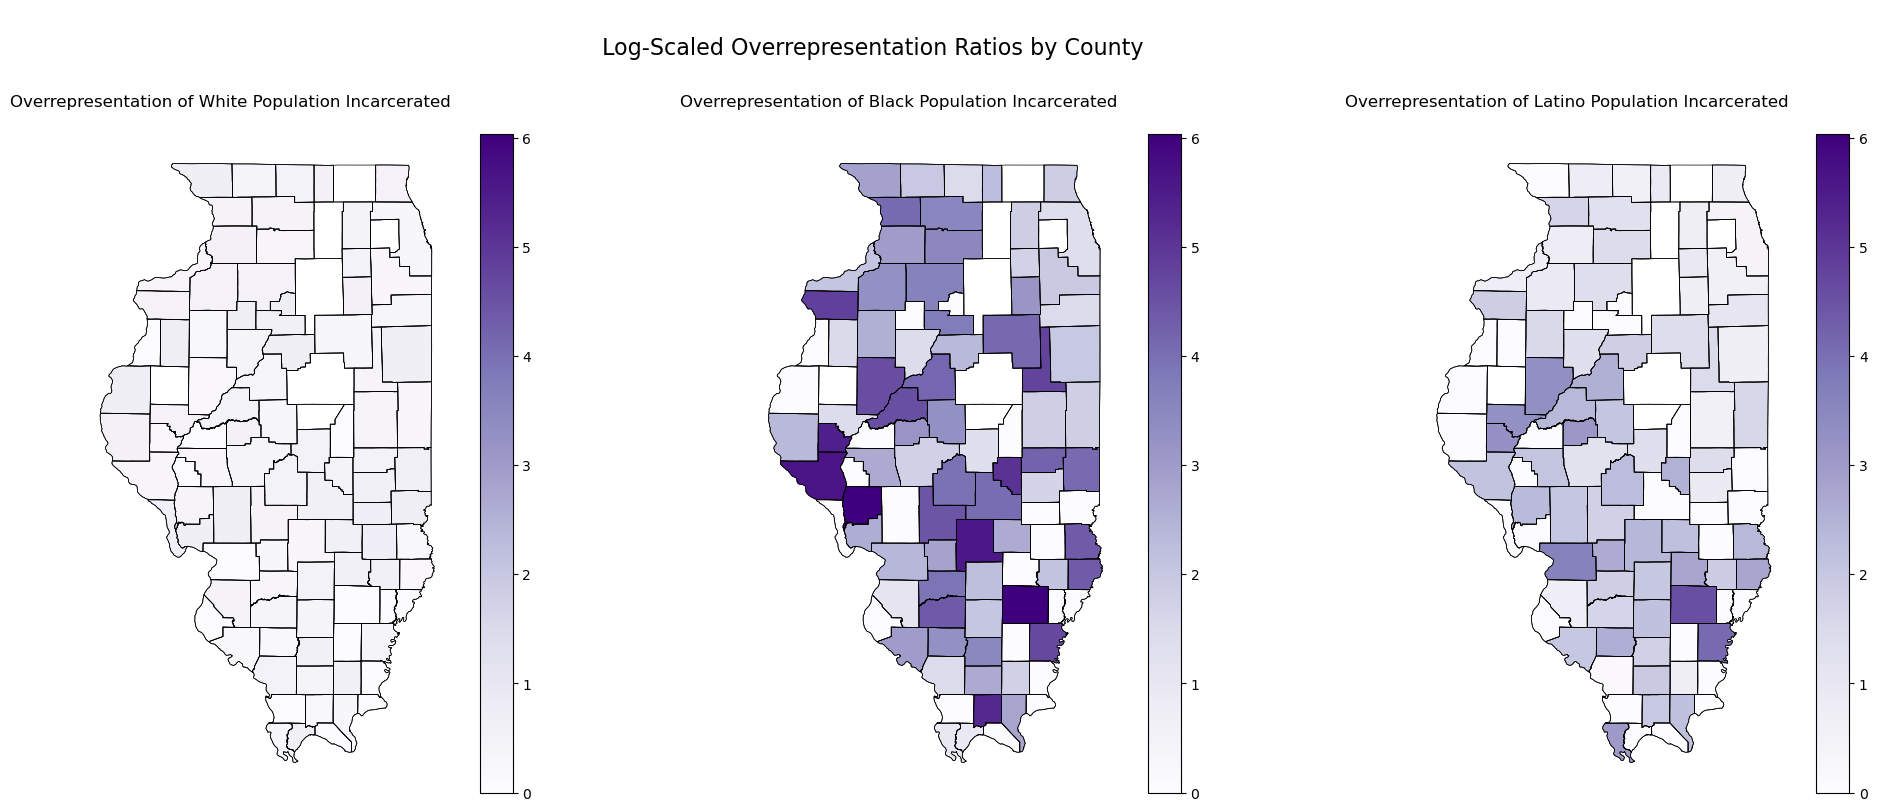

In [580]:
titles = [
    "Overrepresentation of White Population Incarcerated",
    "Overrepresentation of Black Population Incarcerated",
    "Overrepresentation of Latino Population Incarcerated"
]

# Apply log scaling to ratios and store in new columns
for ratio in ratios_to_plot:
    merged_demographics[f'log_{ratio}'] = np.log1p(merged_demographics[ratio])  # log1p avoids log(0)

# Combine all log-scaled ratios to get global color scale
all_log_ratios = pd.concat([
    merged_demographics[f'log_{ratios_to_plot[0]}'],
    merged_demographics[f'log_{ratios_to_plot[1]}'],
    merged_demographics[f'log_{ratios_to_plot[2]}']
], axis=0)

# Get global color scale for log values
vmin, vmax = all_log_ratios.min(), all_log_ratios.max()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), constrained_layout=True)

# Plot each log-scaled ratio
for i, ratio in enumerate(ratios_to_plot):
    # BASE LAYER: Plot county boundaries
    illinois_counties.boundary.plot(
        ax=axes[i],
        linewidth=0.5,
        color="black"
    )

    # OVERLAY: Plot the log-transformed ratio data
    merged_demographics.plot(
        column=f'log_{ratio}',
        cmap='Purples',
        linewidth=0.5,
        edgecolor='black',
        ax=axes[i],
        legend=True,
        vmin=vmin,  # Global log scale min
        vmax=vmax   # Global log scale max
    )
    
    # Centered titles
    axes[i].set_title(titles[i], fontsize=12, loc='center', pad=20, x=0.4)

    axes[i].set_axis_off()  # Hide axes for clean appearance

plt.suptitle("\n Log-Scaled Overrepresentation Ratios by County \n", fontsize=16)

plt.show()

The maps above show **log-scaled overrepresentation ratios** for incarcerated White, Black, and Latino populations by county in Illinois. When examined alongside the rural-urban classification from **Appendix A**, clear patterns emerge. For the **Black population**, overrepresentation is strikingly concentrated in rural counties, particularly in southern and central Illinois. These areas, despite having smaller Black populations, show higher overrepresentation ratios, likely due to systemic disparities magnified by the demographic imbalance. Urban areas, such as Cook County (Chicago), do not show significant overrepresentation, which is surprising. However, this could be explained by Cook County’s large Black population, which may stabilize the incarceration ratio and reduce its visibility on a log-scaled measure. In contrast, the **White population** shows minimal overrepresentation across both rural and urban counties, with very few areas displaying notable disparities. For the **Latino population**, overrepresentation appears more concentrated in southern and central rural counties, with some isolated counties in the north and west also showing elevated ratios. This suggests that incarceration disparities for Latinos are more localized compared to the widespread patterns observed for Black individuals. The findings reinforce how rural counties, with smaller minority populations, experience disproportionate incarceration rates, while urban areas like Cook County exhibit less extreme disparities—possibly due to higher baseline minority populations. These trends highlight the need to contextualize overrepresentation ratios within the demographic makeup of each county.

### Hypothesis Testing

#### Kruskal-Wallis Test:
The Kruskal-Wallis test is appropriate here because the data (log-scaled ratios) does not need to meet normality assumptions, and the test uses ranks rather than raw values, making it robust to skewed data and outliers. The groups being compared—White, Black, and Latino—are independent of each other, which satisfies the test's assumptions.

**Null Hypothesis (H₀):** The medians of the log-scaled overrepresentation ratios are equal across the three racial groups (White, Black, and Latino).

**Alternative Hypothesis (H₁):** At least one group has a median log-scaled overrepresentation ratio that is significantly different from the others.

In [490]:
# Extract log-scaled ratios for each group
white_ratios = merged_demographics[f'log_{ratios_to_plot[0]}'].dropna()
black_ratios = merged_demographics[f'log_{ratios_to_plot[1]}'].dropna()
latino_ratios = merged_demographics[f'log_{ratios_to_plot[2]}'].dropna()

# Kruskal-Wallis Test to check for overall differences
h_stat, p_val = kruskal(white_ratios, black_ratios, latino_ratios)
print(f"Kruskal-Wallis Test: H-statistic = {h_stat:.4f}, p-value = {p_val:.4f}")


Kruskal-Wallis Test: H-statistic = 62.1876, p-value = 0.0000


Since the p-value = 0.0000 (far below the significance threshold of 0.05), the null hypothesis is rejected. The test result indicates that there are significant differences in the medians of the log-scaled overrepresentation ratios between at least one pair of racial groups (White, Black, and Latino).

To identify which groups are significantly different from each other, you should perform pairwise comparisons using a post-hoc test such as the Mann-Whitney U Test with a correction for multiple comparisons (e.g., Bonferroni adjustment).


#### Pairwise Mann-Whitney U Tests:

The **Mann-Whitney U Test** was used to complement the Kruskal-Wallis test by conducting pairwise comparisons of total arrests between racial groups: White, Black, and Latino. This test was appropriate because it is **non-parametric**, meaning it does not require the data to meet normality assumptions, by comparing **two independent groups** at a time, it becomes suitable for pairwise analyses. Instead of using raw values, the Mann-Whitney U Test evaluates **rank distributions**, which makes it effective for handling skewed data and outliers. It is also well-suited for datasets with smaller sample sizes or unequal group sizes, making it a strong choice for this analysis.   

**Null Hypothesis (H₀):**  
There is no significant difference in total arrests between the two racial groups being compared.  

**Alternative Hypothesis (H₁):**  
There is a significant difference in total arrests between the two racial groups being compared.  

The Mann-Whitney U Test was performed for all pairwise comparisons (e.g., White vs. Black, White vs. Latino, Black vs. Latino). Results with **p-values < 0.05** indicate significant differences between the groups.

In [491]:
from scipy.stats import mannwhitneyu

# Pairwise Mann-Whitney U Tests with Bonferroni Adjustment - Only rAn if Kruskal-Wallis indicates significance
print("\nPerforming pairwise Mann-Whitney U Tests with Bonferroni Adjustment:")
pairs = [('White', white_ratios), ('Black', black_ratios), ('Latino', latino_ratios)]
num_comparisons = len(pairs) * (len(pairs) - 1) // 2  # Total number of pairwise comparisons
alpha_adjusted = 0.05 / num_comparisons  # Adjusted significance level

for i in range(len(pairs)):
    for j in range(i + 1, len(pairs)):
        group1_name, group1 = pairs[i]
        group2_name, group2 = pairs[j]
        u_stat, p_val_pair = mannwhitneyu(group1, group2, alternative='two-sided')
        
        # Check if p-value is below the adjusted threshold
        print(f"{group1_name} vs {group2_name}: U-statistic = {u_stat:.4f}, "
                f"p-value = {p_val_pair:.4f}")

print(f"\nBonferroni-adjusted significance level: {alpha_adjusted:.4f}")



Performing pairwise Mann-Whitney U Tests with Bonferroni Adjustment:
White vs Black: U-statistic = 1848.0000, p-value = 0.0000
White vs Latino: U-statistic = 2591.5000, p-value = 0.0000
Black vs Latino: U-statistic = 6162.5000, p-value = 0.0000

Bonferroni-adjusted significance level: 0.0167


The results of the pairwise **Mann-Whitney U tests** with a Bonferroni-adjusted significance level of **0.0167** are as follows:

- **White vs Black**: The p-value is below the adjusted threshold, indicating a **significant difference** in total arrests between White and Black individuals.  

- **White vs Latino**: The p-value is below the adjusted threshold, indicating a **significant difference** in total arrests between White and Latino individuals.  

- **Black vs Latino**: The p-value is below the adjusted threshold, indicating a **significant difference** in total arrests between Black and Latino individuals.  

All pairwise comparisons (White vs Black, White vs Latino, and Black vs Latino) show statistically **significant differences** in total arrests. The Bonferroni adjustment ensures that these results account for multiple comparisons, reducing the risk of false positives.  

## Implications
The geographic analysis reveals critical disparities in the distribution of wrongful convictions and arrests across Illinois counties, highlighting how these issues are both systemic and spatially concentrated. **Urban counties, particularly Cook County, dominate the data, with exonerations and arrests far exceeding those observed in rural areas. This concentration reflects broader systemic patterns where urban regions experience higher policing volumes, larger caseloads, and more pronounced racial disparities.** The findings underscore that wrongful convictions are not isolated incidents but are intricately tied to urban policing practices and the disproportionate targeting of Black individuals, who bear the heaviest burden of both arrests and misconduct leading to exonerations. In rural counties, such as **Livingston** and **Macon**, exonerations and arrests appear minimal in comparison. While this could reflect smaller populations or reduced legal activity, the trends in rural areas still warrant attention. The overrepresentation ratios observed in rural counties (see Appendix A) reveal significant disparities, particularly for Black individuals. Even in regions with smaller Black populations, incarceration and arrest rates remain disproportionate, magnifying systemic biases against minority groups within less densely populated areas.

By balancing **logarithmic scaling** to visualize statewide trends and **linear scaling** to highlight regional nuances, this analysis demonstrates that systemic failures in the justice system are pervasive yet vary in scale across urban and rural settings. Urban areas like Cook County exemplify the most severe disparities, driven by population density and over-policing of Black communities. At the same time, rural counties exhibit subtler but still significant patterns of racialized injustice.

# Disproportionality Analysis

## Disproportionality Index

The **Corporation for Supportive Housing (CSH)** created the **Racial Disparities and Disproportionality Index (RDDI)** to assess disproportionality across systems, including housing data. Drawing on the same foundational principles, I developed an adapted index specifically for my dataset [@csh_rddi].  

The following version of the index measures whether a group’s presence in a given system—such as arrests, over-policing, or exonerations—is proportional to their overall population share. By centering equity-driven analysis, it highlights patterns of overrepresentation and underrepresentation across racial and ethnic groups, providing a clearer view of systemic disparities within these systems.  

To interpret the index:  
- A value **greater than 1** indicates **overrepresentation** within the system.  
- A value **less than 1** indicates **underrepresentation** within the system.  
- A value of **exactly 1** reflects **parity**, meaning the group's representation is proportional to their overall population.   

### Exonerations vs. Incarcerated Population by Race

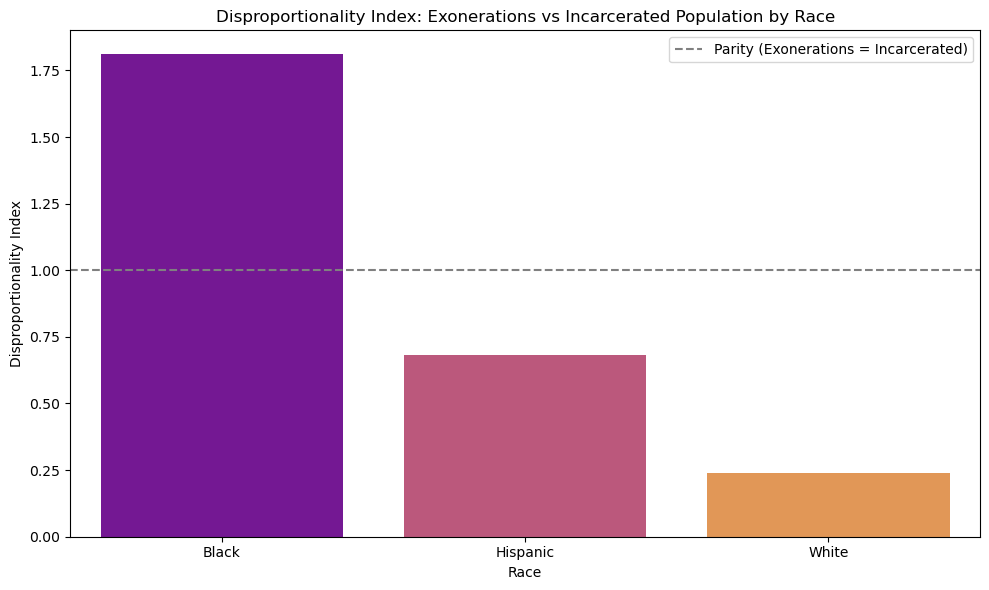

In [492]:
# Aggregate exoneration counts by race and county
exonerees_by_race_county = exon_df.groupby(['race', 'county']).size().reset_index(name='exonerees')

# Merge exonerations with demographic data on race and county
merged_exonerees_demo = exonerees_by_race_county.merge(
    merged_demographics, 
    on='county', 
    how='left'
)

# Filter only valid races present in the demographic data
valid_races = ['White', 'Black', 'Hispanic']  # Exclude Asian and Native American
merged_exonerees_demo = merged_exonerees_demo[merged_exonerees_demo['race'].isin(valid_races)]

# Aggregate incarcerated population by race
incarcerated_by_race = merged_exonerees_demo.groupby('race')[
    ['incarcerated_white_population', 'incarcerated_black_population', 'incarcerated_latino_population']
].sum()

# Map the columns to their respective race labels
incarcerated_by_race = incarcerated_by_race.rename(columns={
    'incarcerated_white_population': 'White',
    'incarcerated_black_population': 'Black',
    'incarcerated_latino_population': 'Hispanic'
})

# Sum incarcerated population for valid races only
incarcerated_total = incarcerated_by_race.sum(axis=1)

# Calculate total exonerations by race
exonerations_by_race = merged_exonerees_demo.groupby('race')['exonerees'].sum()

# Calculate percentages
incarcerated_percent = incarcerated_total / incarcerated_total.sum()
exoneration_percent = exonerations_by_race / exonerations_by_race.sum()

# Calculate disproportionality index
disproportionality_index = (exoneration_percent / incarcerated_percent).fillna(0)

# Convert to DataFrame for plotting
disproportionality_df = disproportionality_index.reset_index()
disproportionality_df.columns = ['race', 'disproportionality_index']

# Plot disproportionality index
plt.figure(figsize=(10, 6))
sns.barplot(data=disproportionality_df, x='race', y='disproportionality_index', palette='plasma')
plt.title("Disproportionality Index: Exonerations vs Incarcerated Population by Race")
plt.xlabel("Race")
plt.ylabel("Disproportionality Index")
plt.axhline(y=1, color='gray', linestyle='--', label="Parity (Exonerations = Incarcerated)")
plt.legend()
plt.tight_layout()
plt.show()


The graph displays the **Disproportionality Index** comparing exonerations to the incarcerated population by race. The dashed line at 1.0 represents **parity**, where exonerations would align proportionally with incarceration rates. For the **Black population**, the index value significantly exceeds 1.0, indicating that Black individuals are overrepresented in exonerations relative to their incarceration rate. This suggests systemic issues that may lead to wrongful convictions disproportionately impacting Black communities. In contrast, the **Hispanic population** shows an index value below 1.0 but higher than that of White individuals. While there is some disproportionality, it is less pronounced compared to the Black population. The **White population** has the lowest index value, well below 1.0, indicating that White individuals are underrepresented in exonerations relative to their incarceration rate. This may suggest fewer wrongful convictions or more favorable outcomes for White individuals within the criminal justice system. Overall, the graph highlights a clear racial disparity, with Black individuals experiencing the greatest disproportionality in exonerations—a trend that underscores deeper systemic inequities within the justice system.  

### Exonerations vs. Arrests by Race
Exonerations reflect wrongful convictions that result from arrests, while arrests represent the volume of individuals taken into custody by law enforcement—a proxy for policing practices. The **Disproportionality Index: Exonerations vs. Arrests** provides a way to analyze whether certain racial groups experience wrongful convictions at rates disproportionate to their arrest volumes.  

If the ratio of exonerations to arrests is higher for a specific race, it suggests that individuals within that group are being wrongfully arrested and convicted at disproportionately high rates relative to how often they are arrested. This can be interpreted as an indicator of **over-policing** or bias in policing practices, where arrests occur at a higher rate without sufficient cause, increasing the likelihood of wrongful convictions.  

While this measure highlights the connection between arrests and wrongful convictions, it is distinct from analyzing **exonerations vs. the incarcerated population**. Exonerations compared to incarceration rates highlight broader issues of systemic bias within the criminal justice system, focusing on who remains incarcerated unjustly. Meanwhile, exonerations compared to arrests emphasize the front-end policing practices—who is being taken into custody in the first place and whether those arrests were justified.  

By using both comparisons—**exonerations vs. arrests** and **exonerations vs. incarceration**—it becomes possible to capture the full scope of disparities, from over-policing to wrongful incarceration, and to identify where systemic failures occur across different stages of the justice process.  

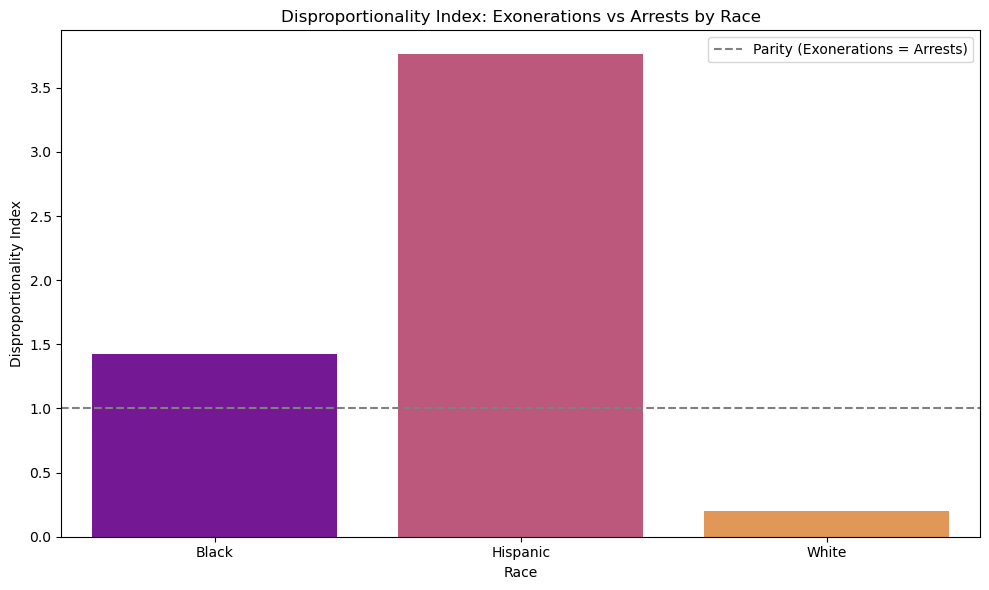

In [493]:
# Aggregate exoneration counts by race and county
exonerees_by_race_county = exon_df.groupby(['race', 'county']).size().reset_index(name='exonerees')
# Merge exonerees and arrests by race and county
merged_exoneree_arrest = exonerees_by_race_county.merge(
    aggregated_data_melted, on=['race', 'county'], how='left'
)

# Fill NaN values in arrests with 0 (in case no arrests are recorded for a county)
merged_exoneree_arrest['total_arrests'] = merged_exoneree_arrest['total_arrests'].fillna(0)

# Filter out races that are not relevant (Asian and Native American)
valid_races = ['White', 'Black', 'Hispanic']
merged_exoneree_arrest = merged_exoneree_arrest[merged_exoneree_arrest['race'].isin(valid_races)]

# Calculate total arrests and exonerations by race
total_arrests_by_race = merged_exoneree_arrest.groupby('race')['total_arrests'].sum()
total_exonerations_by_race = merged_exoneree_arrest.groupby('race')['exonerees'].sum()

# Calculate percentages
arrest_percent = total_arrests_by_race / total_arrests_by_race.sum() * 100
exoneration_percent = total_exonerations_by_race / total_exonerations_by_race.sum() * 100

# Calculate disproportionality index
disproportionality = (exoneration_percent / arrest_percent).fillna(0)

# Convert to DataFrame for plotting
disproportionality_df = disproportionality.reset_index()
disproportionality_df.columns = ['race', 'disproportionality_index']

# Plot disproportionality index
plt.figure(figsize=(10, 6))
sns.barplot(data=disproportionality_df, x='race', y='disproportionality_index', palette='plasma')
plt.title("Disproportionality Index: Exonerations vs Arrests by Race")
plt.xlabel("Race")
plt.ylabel("Disproportionality Index")
plt.axhline(1, color='gray', linestyle='--', label="Parity (Exonerations = Arrests)")
plt.legend()
plt.tight_layout()
plt.show()


The **Disproportionality Index** graph comparing exonerations to arrests initially indicates significant disparities, particularly for Hispanic individuals. At first glance, the Hispanic group exhibits the highest disproportionality index—well above parity—suggesting that exonerations are disproportionately high relative to their arrest volume. However, this observation requires further scrutiny when considering the raw counts of total arrests and exonerations.  


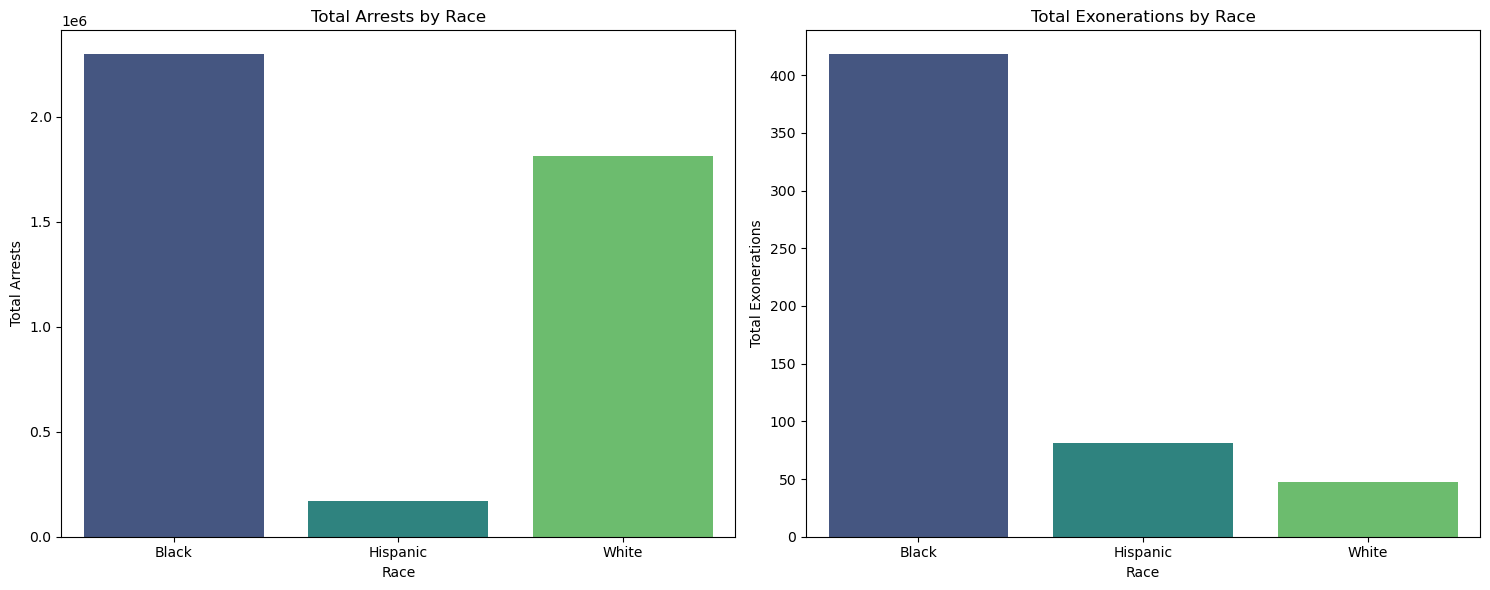

In [494]:
# Calculate raw counts for context
race_counts = merged_exoneree_arrest.groupby('race')[['exonerees', 'total_arrests']].sum().reset_index()

# Plot raw counts for comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot total arrests
sns.barplot(data=race_counts, x='race', y='total_arrests', ax=axes[0], palette='viridis')
axes[0].set_title("Total Arrests by Race")
axes[0].set_ylabel("Total Arrests")
axes[0].set_xlabel("Race")

# Plot total exonerations
sns.barplot(data=race_counts, x='race', y='exonerees', ax=axes[1], palette='viridis')
axes[1].set_title("Total Exonerations by Race")
axes[1].set_ylabel("Total Exonerations")
axes[1].set_xlabel("Race")

plt.tight_layout()
plt.show()


In the second visualization of **Total Arrests vs. Total Exonerations by Race**, its evident that while the Hispanic population has a high disproportionality index, this result is influenced by the **small number of arrests relative to other groups**. For example, Black individuals have the highest total arrests (over 2.2 million) and the highest number of exonerations (418), while White individuals follow closely in arrests (1.8 million) but have significantly fewer exonerations (47). In contrast, the Hispanic group has a much smaller total arrest count (1.68 million) and a moderate number of exonerations (81).  


In [495]:
# Summarize counts by race
race_summary = merged_exoneree_arrest.groupby('race').agg(
    total_arrests=('total_arrests', 'sum'),
    total_exonerees=('exonerees', 'sum')
).reset_index()

pd.set_option('display.max_columns', None)  
race_summary

,race,total_arrests,total_exonerees
0,Black,2297196.0,418
1,Hispanic,168944.0,81
2,White,1815269.0,47


In [496]:
total_arrests_sum = race_summary["total_arrests"].sum()
print ("Total Arrest Volume: ", total_arrests_sum)

Total Arrest Volume:  4281409.0


To address this, I implemented a **threshold** of 170,000 total arrests—approximately **4% of the total arrest volume**—to filter out racial groups with insufficient arrest counts. This ensures that the results are not skewed by small sample sizes. For example, the Hispanic group, with a total of 168,944 arrests, makes up just under 4% of all arrests. By setting this threshold, the analysis excludes groups with arrest counts below this level, preventing inflated disproportionality indices caused by smaller numbers.  

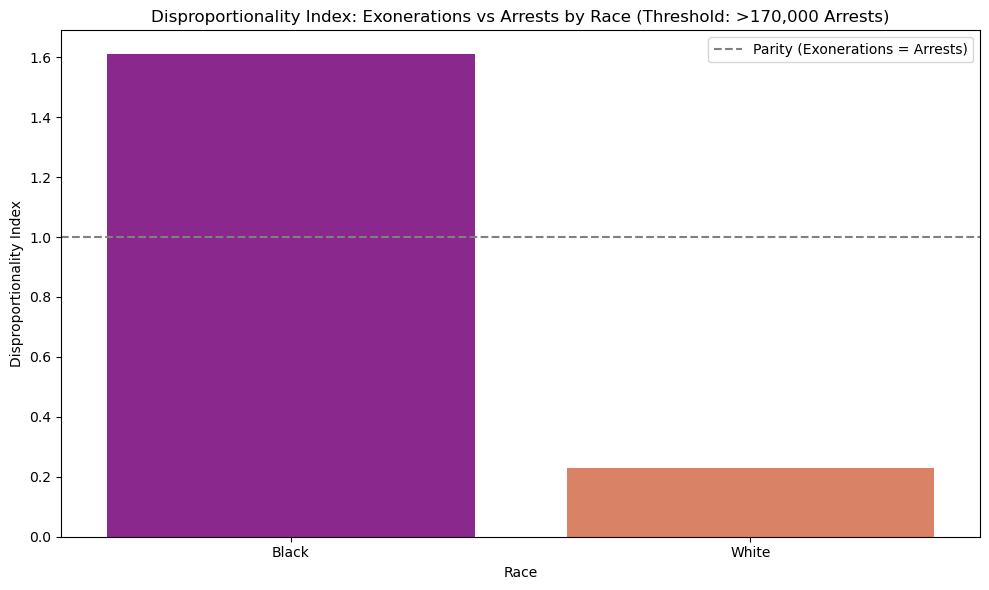

In [497]:
# Apply threshold: Only include races with total arrests > 100,000
total_arrests_by_race = total_arrests_by_race[total_arrests_by_race >170000]
valid_races_with_threshold = total_arrests_by_race.index  # Get the races that meet the threshold

# Filter exoneration counts to match the races above
total_exonerations_by_race = total_exonerations_by_race[total_exonerations_by_race.index.isin(valid_races_with_threshold)]

# Calculate percentages
arrest_percent = total_arrests_by_race / total_arrests_by_race.sum() * 100
exoneration_percent = total_exonerations_by_race / total_exonerations_by_race.sum() * 100

# Calculate disproportionality index
disproportionality = (exoneration_percent / arrest_percent).fillna(0)

# Convert to DataFrame for plotting
disproportionality_df = disproportionality.reset_index()
disproportionality_df.columns = ['race', 'disproportionality_index']

# Plot disproportionality index
plt.figure(figsize=(10, 6))
sns.barplot(data=disproportionality_df, x='race', y='disproportionality_index', palette='plasma')
plt.title("Disproportionality Index: Exonerations vs Arrests by Race (Threshold: >170,000 Arrests)")
plt.xlabel("Race")
plt.ylabel("Disproportionality Index")
plt.axhline(1, color='gray', linestyle='--', label="Parity (Exonerations = Arrests)")
plt.legend()
plt.tight_layout()
plt.show()

The updated disproportionality index focuses on racial groups with a substantial share of arrests, providing a clearer and more accurate analysis. By applying a **170,000 threshold**, which represents **4% of the total arrest volume**, groups with smaller arrest counts—like the Hispanic population—are filtered out. This prevents inflated indices caused by small sample sizes. As a result, the analysis reveals that Black individuals remain disproportionately exonerated relative to their arrest rate, while the previously observed Hispanic disproportionality becomes more contextualized when considering their smaller overall share of arrests.  

#### Why This Matters  
This process demonstrates that while initial disproportionality measures can highlight disparities, raw counts and thresholds are essential for providing context. Smaller arrest volumes can distort disproportionality indices, leading to misleading conclusions about systemic disparities. By introducing a threshold, the analysis ensures that overrepresentation is evaluated fairly, accurately, and meaningfully across racial groups with a substantial presence in the data.  


### Implications
The disproportionality analysis highlights profound racial disparities across multiple stages of the criminal justice system, from arrests to exonerations. **Black individuals experience the highest disproportionality in exonerations relative to both arrests and incarceration rates.** This suggests that Black communities face systemic failures at multiple levels: they are overpoliced, wrongfully arrested, and disproportionately subjected to wrongful convictions. These findings reinforce how deeply racial bias is embedded within law enforcement and prosecutorial practices, culminating in devastating injustices. The comparison of **exonerations to arrests** is particularly illuminating, as it exposes front-end policing failures. Over-policing in predominantly Black communities results in high arrest volumes, increasing the likelihood of wrongful convictions. Despite representing a disproportionate share of total arrests, Black individuals are also exonerated at disproportionately high rates, signaling a clear breakdown in the legitimacy of these arrests and the justice process that follows.  

The analysis initially identified Hispanic individuals with an elevated disproportionality index in exonerations relative to arrests. Applying a threshold of **170,000 arrests**—approximately 4% of the total arrest volume—helps contextualize this result by accounting for smaller arrest counts that can inflate the index. However, as the other data shows, Hispanic individuals do have higher arrest and incarceration rates than White individuals, with values that are the **second highest** after Black individuals. While their overall arrest volume is smaller than that of Black or White populations, the higher disproportionality index underscores that wrongful convictions still impact Hispanic individuals at elevated rates relative to their arrest volume. The updated analysis focuses on racial groups with substantial arrest volumes while reinforcing that these disparities remain significant.  

**In sum, this analysis underscores how racial bias and systemic flaws converge at every stage of the justice process—arrests, convictions, and eventual exonerations—disproportionately impacting Black individuals.**

# Official Misconduct (OM) Anaysis
This section conducts a comprehensive analysis of **official misconduct** in wrongful conviction cases. The approach includes calculating frequencies of misconduct tags, identifying distributions, and analyzing patterns by race and location.  

## Frequency of OM Tags in Exoneration Cases
This visualization provides a clear understanding of which forms of official misconduct are most prevalent in wrongful conviction cases. By identifying trends, the analysis underscores systemic issues in the criminal justice system that contribute to these injustices.

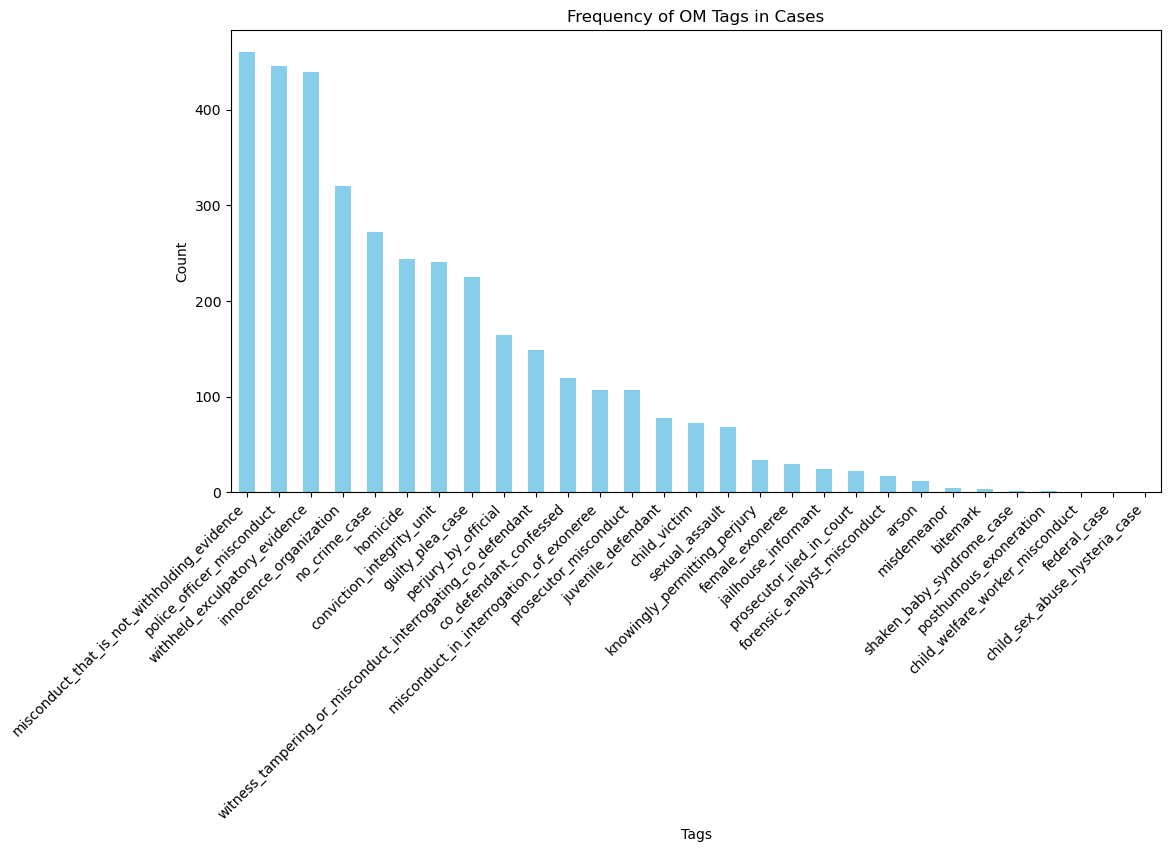

In [578]:
# Count the frequency of each tag
tag_columns = [
    'arson', 'bitemark', 'co_defendant_confessed', 'conviction_integrity_unit',
    'child_sex_abuse_hysteria_case', 'child_victim', 'female_exoneree', 
    'federal_case', 'homicide', 'innocence_organization', 'jailhouse_informant', 
    'juvenile_defendant', 'misdemeanor', 'no_crime_case', 'guilty_plea_case', 
    'posthumous_exoneration', 'sexual_assault', 'shaken_baby_syndrome_case',
    'prosecutor_misconduct', 'police_officer_misconduct', 'forensic_analyst_misconduct', 
    'child_welfare_worker_misconduct', 'withheld_exculpatory_evidence',
    'misconduct_that_is_not_withholding_evidence', 'knowingly_permitting_perjury', 
    'witness_tampering_or_misconduct_interrogating_co_defendant',
    'misconduct_in_interrogation_of_exoneree', 'perjury_by_official', 
    'prosecutor_lied_in_court'
]

# Count occurrences of each tag
tag_counts = exon_df[tag_columns].sum().sort_values(ascending=False)
tag_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title("Frequency of OM Tags in Cases")
plt.ylabel("Count")
plt.xlabel("Tags")
plt.xticks(rotation=45, ha='right')
plt.show()


The bar chart displays the **frequency of official misconduct tags** across all wrongful conviction cases. Each tag represents a specific type of misconduct, and the height of the bars indicates how often each tag appears. At a glance, misconduct types like **"misconduct_that_is_not_withholding_evidence," "police officer misconduct,"** and **"withheld_exculpatory_evidence"** dominate the chart, highlighting the most common failures contributing to wrongful convictions. These categories reveal recurring patterns of negligence or deliberate misconduct within the justice system, particularly by law enforcement and prosecutors. Tags toward the right, such as **"child_welfare_worker_misconduct"** or **"child_sex_abuse_hysteria_case,"** occur far less frequently, suggesting that while impactful, they play a smaller role in the Illinois dataset compared to the more systemic issues seen on the left side of the chart. The visual clearly underscores how **evidentiary issues**, **misconduct by officials**, and **failures during investigations** are central drivers of wrongful convictions. These patterns expose the depth of systemic flaws and provide insight into where reforms in accountability and oversight are most urgently needed.  

## Total Tags Per Case and County-Level Distribution  
The **distribution of total tags per case** is explored through a histogram with a density curve. This visualization shows how many misconduct tags are typically associated with each wrongful conviction case, revealing the overall frequency and variability of misconduct on a case-by-case basis.  

The analysis is further refined at the **county level** using a boxplot, showing how the total number of misconduct tags varies across different counties. This highlights geographical disparities, with some counties exhibiting higher concentrations of misconduct tags than others.  


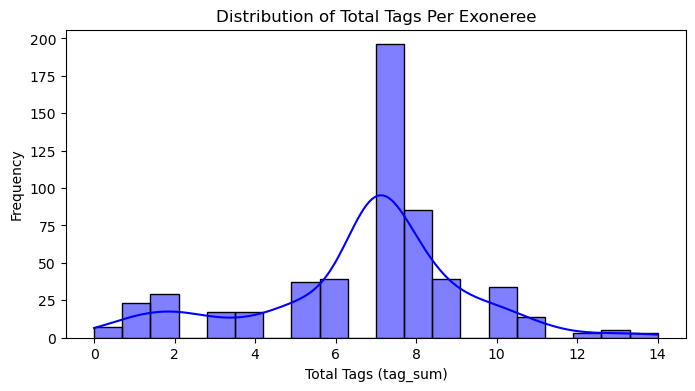

In [592]:
# Distribution of tag_sum
plt.figure(figsize=(8, 4))
sns.histplot(exon_df['tag_sum'], kde=True, bins=20, color='blue')
plt.title("Distribution of Total Tags Per Exoneree")
plt.xlabel("Total Tags (tag_sum)")
plt.ylabel("Frequency")
plt.show()


The histogram visualizes the **distribution of total misconduct tags per exoneree**, providing insight into how many official misconduct types are typically associated with individual wrongful conviction cases. The inclusion of a **density curve** smooths the distribution, highlighting the overall shape of the data. The distribution reveals that most cases cluster around a **total tag count of 6 to 8**, indicating that these cases often involve multiple forms of misconduct. Fewer cases fall on the extremes, with some showing very low or very high tag counts.  

This visualization emphasizes that wrongful convictions are rarely tied to a single instance of misconduct. Instead, they are often characterized by a combination of failures, such as withheld evidence, perjury, or misconduct by officials, compounding the harm inflicted on exonerees. By analyzing this distribution, the data underscores the systemic and multifaceted nature of official misconduct in wrongful conviction cases.  

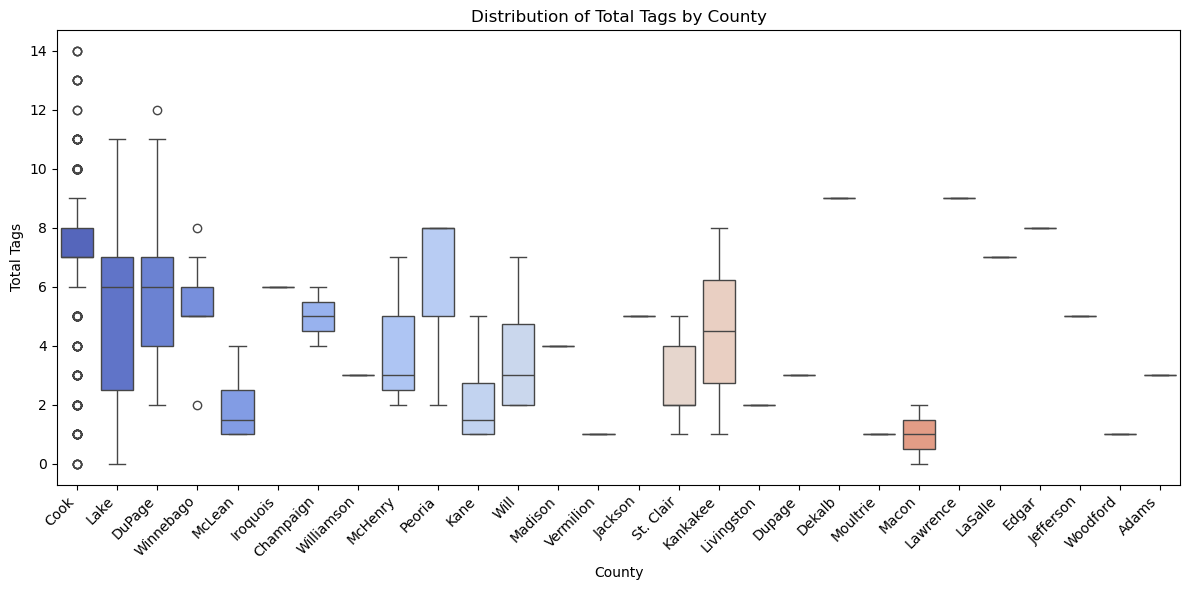

In [554]:
# Tag sum by county
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='county', y='tag_sum', palette='coolwarm')
plt.title("Distribution of Total Tags by County")
plt.xlabel("County")
plt.ylabel("Total Tags")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The boxplot reveals **significant disparities** in the total number of misconduct tags across Illinois counties, with a clear distinction between urban and rural areas. Counties like **Lake, Kane, and St. Clair**, which appear to have higher tag counts and greater variability, are classified as **urban counties** (Appendix A). The combination of higher population densities and heavier caseloads in urban areas may contribute to the increased prevalence of official misconduct in wrongful conviction cases.  

On the other hand, counties such as **Lawrence** and **Macon**, which display consistently lower tag counts, are classified as **rural counties** (Appendix A). This may reflect fewer documented wrongful conviction cases or less reporting of official misconduct in these areas. Rural counties tend to have smaller populations and fewer legal resources, which could limit the exposure or identification of misconduct.  

These findings highlight a broader systemic pattern where urban counties, with their larger legal infrastructures and caseloads, see higher instances of misconduct tied to wrongful convictions. Meanwhile, rural counties may experience underreporting or lack the capacity to fully document similar issues. The urban-rural divide, as outlined in Appendix A, provides critical context for understanding these regional disparities.  

## Misconduct Tags by Race  
This visualization examines the total number of misconduct tags across racial groups to highlight racial disparities in wrongful convictions. Misconduct tags are aggregated for each race, providing a clear view of which groups are disproportionately impacted by official misconduct.  

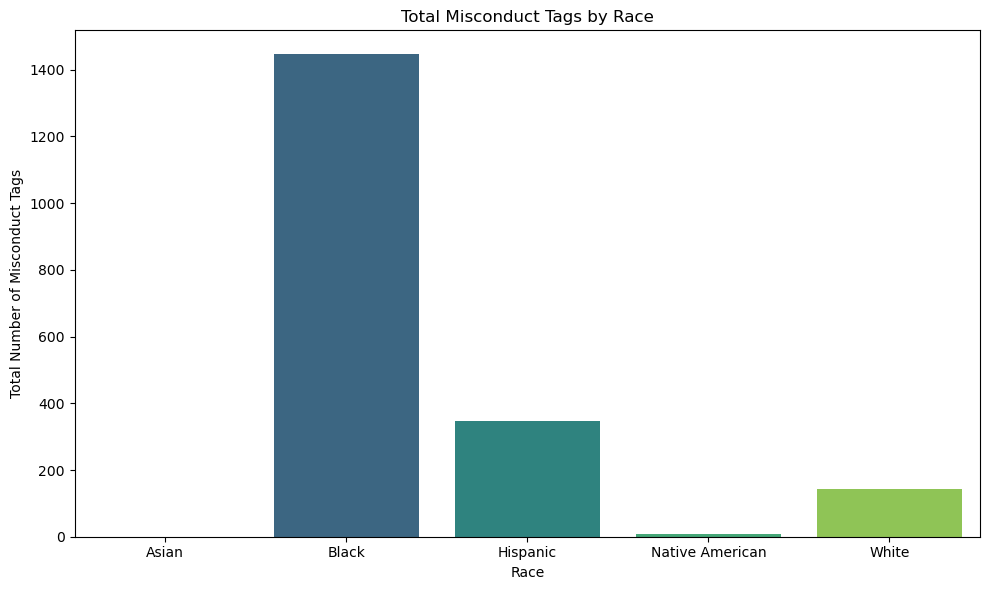

In [566]:
# Group misconduct-related tags
misconduct_tags = [
    'prosecutor_misconduct', 'police_officer_misconduct', 
    'forensic_analyst_misconduct', 'child_welfare_worker_misconduct',
    'withheld_exculpatory_evidence', 'misconduct_that_is_not_withholding_evidence',
    'knowingly_permitting_perjury', 'witness_tampering_or_misconduct_interrogating_co_defendant',
    'misconduct_in_interrogation_of_exoneree', 'perjury_by_official', 
    'prosecutor_lied_in_court'
]

# Create a column for combined misconduct
exon_df['total_misconduct'] = exon_df[misconduct_tags].sum(axis=1)

# Aggregate total misconduct by race (using sum for total counts)
race_misconduct = exon_df.groupby('race')['total_misconduct'].sum().reset_index()

# Bar plot of total misconduct by race
plt.figure(figsize=(10, 6))
sns.barplot(data=race_misconduct, x='race', y='total_misconduct', palette='viridis')
plt.title("Total Misconduct Tags by Race")
plt.xlabel("Race")
plt.ylabel("Total Number of Misconduct Tags")
plt.tight_layout()
plt.show()



The chart makes clear the staggering racial disparities in official misconduct tied to wrongful convictions. Black exonerees face an overwhelming burden, with the total number of misconduct tags far exceeding that of any other racial group. This disparity underscores how deeply systemic bias and official misconduct are embedded within the criminal legal system, disproportionately impacting Black individuals at every level.  Hispanic exonerees follow but with significantly fewer misconduct tags, while White and Native American exonerees show even lower counts. Asian exonerees, by contrast, have virtually no recorded instances of misconduct tags, which may reflect reporting gaps or smaller representation in the dataset rather than an absence of misconduct. The magnitude of misconduct affecting Black exonerees highlights a critical failure in accountability and exposes racialized patterns of injustice within wrongful convictions.  

### Hypothesis Testing 

#### Shapiro-Wilk Test For Normality 
The Shapiro-Wilk test is used to determine if the total misconduct tags for each racial group are normally distributed. It is appropriate here because it is sensitive to deviations from normality and works well for small to moderately sized datasets, ensuring that the assumptions of parametric tests like ANOVA are met.

**Null Hypothesis (H₀):** The OM misconduct tags are normally distributed for each racial group.

**Alternative Hypothesis (H₁):** The OM misconduct tags are not normally distributed for each racial group.


In [569]:
from scipy.stats import f_oneway, shapiro, levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

# Check counts of total_misconduct for each race
race_counts = exon_df.groupby('race')['total_misconduct'].count()
print("Counts of total_misconduct by race:")
print(race_counts)

# Filter out groups with fewer than 3 data points
valid_races = race_counts[race_counts >= 3].index
filtered_df = exon_df[exon_df['race'].isin(valid_races)]

# Re-run Shapiro-Wilk Test for Normality
from scipy.stats import shapiro

print("\nShapiro-Wilk Test for Normality (p < 0.05 indicates non-normality):")
for race in valid_races:
    stat, p = shapiro(filtered_df['total_misconduct'][filtered_df['race'] == race])
    print(f"{race}: p-value = {p:.4f}")

Counts of total_misconduct by race:
race
Asian                1
Black              418
Hispanic            81
Native American      1
White               47
Name: total_misconduct, dtype: int64

Shapiro-Wilk Test for Normality (p < 0.05 indicates non-normality):
Black: p-value = 0.0000
Hispanic: p-value = 0.0000
White: p-value = 0.0003


The results of the Shapiro-Wilk test show that the p-values for all racial groups—Black, Hispanic, and White—are below the significance threshold of 0.05, indicating that the total misconduct tags for all groups do not follow a normal distribution. The p-values for Black and Hispanic groups are exactly 0.0000, providing extremely strong evidence against the null hypothesis. For the White group, the p-value is 0.0003, which, while slightly higher, still represents strong evidence that the data is not normally distributed.

#### One-Way ANOVA
The one-way ANOVA test is used here to assess whether there are statistically significant differences in the mean number of total misconduct tags across racial groups. This test is appropriate because it compares the means of more than two independent groups—in this case, racial groups—to determine if the observed differences reflect a real effect or are simply due to random chance.  

ANOVA operates under two key assumptions: that the data within each group is approximately normally distributed and that variances across groups are roughly equal (homogeneity of variances). While the Shapiro-Wilk test showed a violation of the normality assumption, ANOVA is known to be robust to deviations from normality, especially when group sizes are sufficiently large, as with the Black and Hispanic groups in this dataset. For smaller groups, like White, the robustness still holds if interpreted carefully, since ANOVA focuses on identifying differences between group means rather than the exact shape of each group’s distribution.  

**Null Hypothesis (H₀):** There is no significant difference in the mean total misconduct tags between racial groups.  
**Alternative Hypothesis (H₁):** At least one racial group has a significantly different mean total misconduct tag count.  

In [570]:
# Conduct One-Way ANOVA
f_stat, p_anova = f_oneway(*groups)
print(f"\nOne-Way ANOVA Results: F-statistic = {f_stat:.4f}, p-value = {p_anova:.4f}")


One-Way ANOVA Results: F-statistic = 164.6119, p-value = 0.0000


Since the p-value (**0.0000**) is less than the significance threshold of **0.05**, the null hypothesis of the one-way ANOVA is rejected. This result provides statistically significant evidence that there is a difference in the mean total misconduct tags between at least two of the racial groups. However, the ANOVA test itself does not specify which groups are responsible for this difference—it only confirms that not all group means are equal.  

To determine which specific pairs of racial groups have significantly different mean misconduct tags, **post-hoc testing** is performed using **Tukey's HSD**. Tukey’s test compares all possible pairs of group means while controlling for multiple comparisons, ensuring that the results remain statistically valid. By analyzing the output of Tukey's HSD, it becomes possible to identify exactly which racial group comparisons contribute to the overall significance observed in the ANOVA results.  


#### Turkey's HSD Post-hoc Test
The **Tukey's Honest Significant Difference (HSD)** test is conducted as a post-hoc analysis following a significant one-way ANOVA result. This test identifies which specific pairs of groups have significantly different means while controlling for the **family-wise error rate** caused by multiple comparisons. Tukey's HSD is appropriate in this case because the ANOVA test showed a statistically significant difference (**p-value < 0.05**), indicating that at least one pair of racial groups has a significantly different mean number of total misconduct tags.  

Using Tukey's HSD allows for the identification of specific pairs of racial groups with significant differences in their mean misconduct tags. This step is critical for understanding where the disparities occur and which group comparisons contribute to the overall significant ANOVA result. If the output of Tukey's HSD indicates a **"reject"** for particular group comparisons, it confirms that the differences in mean misconduct tags between those groups are statistically significant.  


Performing Tukey's HSD Post-hoc Test:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
          Asian           Black   3.4593 0.3626 -1.7408  8.6595  False
          Asian        Hispanic   4.2963 0.1631 -0.9296  9.5222  False
          Asian Native American      7.0 0.0702 -0.3454 14.3454  False
          Asian           White   3.0638 0.4996 -2.1851  8.3128  False
          Black        Hispanic    0.837 0.0028  0.2064  1.4675   True
          Black Native American   3.5407 0.3384 -1.6595  8.7408  False
          Black           White  -0.3955  0.657 -1.1946  0.4036  False
       Hispanic Native American   2.7037 0.6176 -2.5222  7.9296  False
       Hispanic           White  -1.2325 0.0039 -2.1849 -0.2801   True
Native American           White  -3.9362 0.2426 -9.1851  1.3128  False
--------------------------------------

<Figure size 1000x600 with 0 Axes>

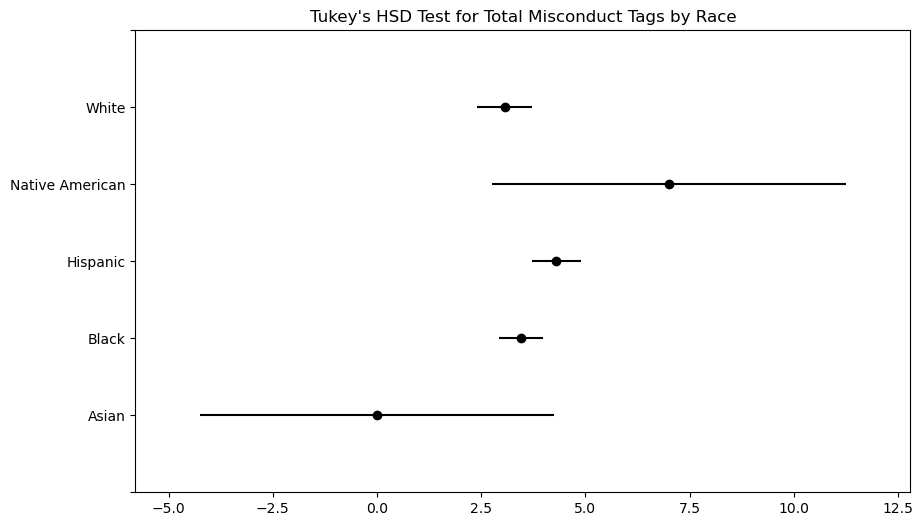

In [572]:
# Post-hoc Test (Tukey's HSD) if ANOVA is significant
print("\nPerforming Tukey's HSD Post-hoc Test:")
tukey = pairwise_tukeyhsd(
    endog=exon_df['total_misconduct'],
    groups=exon_df['race'],
    alpha=0.05
)
print(tukey)

# Visualize Tukey's results
plt.figure(figsize=(10, 6))
tukey.plot_simultaneous()
plt.title("Tukey's HSD Test for Total Misconduct Tags by Race")
plt.show()

The results of the **Tukey's HSD test** reveal significant differences in the mean total misconduct tags between specific racial group pairs. A statistically significant difference is observed between the **Black and Hispanic** groups, as indicated by a very small adjusted p-value (`p-adj`) and a "True" result in the reject column. Similarly, the comparison between the **Hispanic and White** groups shows a significant difference, with an adjusted p-value of **0.0039** and a "True" rejection of the null hypothesis.  

For all other pairwise comparisons—such as **Asian vs Black**, **Asian vs Hispanic**, **Black vs White**, and comparisons involving Native American groups—no statistically significant differences are detected. The confidence intervals for these comparisons include zero, meaning the observed differences are not large enough to be considered statistically significant.  

The accompanying plot provides a visual representation of the **95% confidence intervals** for the mean differences between groups. Each horizontal line represents a confidence interval, and when a line crosses the vertical zero line, it indicates a lack of statistical significance. Significant differences appear only for the **Black-Hispanic** and **Hispanic-White** comparisons, where the confidence intervals remain entirely on one side of zero.  

In conclusion, the Tukey's HSD results demonstrate that disparities in total misconduct tags are particularly evident for the **Hispanic group**, which differs significantly from both the **Black** and **White** groups. For all other group comparisons, no statistically significant differences were identified.  


### Breakdown of OM Types by Race
This heatmap shows the distribution of official misconduct types across racial groups, giving a clear picture of how different forms of misconduct disproportionately affect each group. Misconduct tags are aggregated by race, and the color gradient reflects their frequency, with darker shades indicating higher counts. The x-axis lists the specific types of misconduct, while the y-axis categorizes racial groups. Annotated values within each cell provide the exact counts, making the patterns easy to interpret both visually and numerically. By breaking down the data this way, the visualization reveals which types of official misconduct are most prevalent for each racial group, underscoring systemic disparities and offering a foundation for deeper analysis of how misconduct manifests across racial lines.  

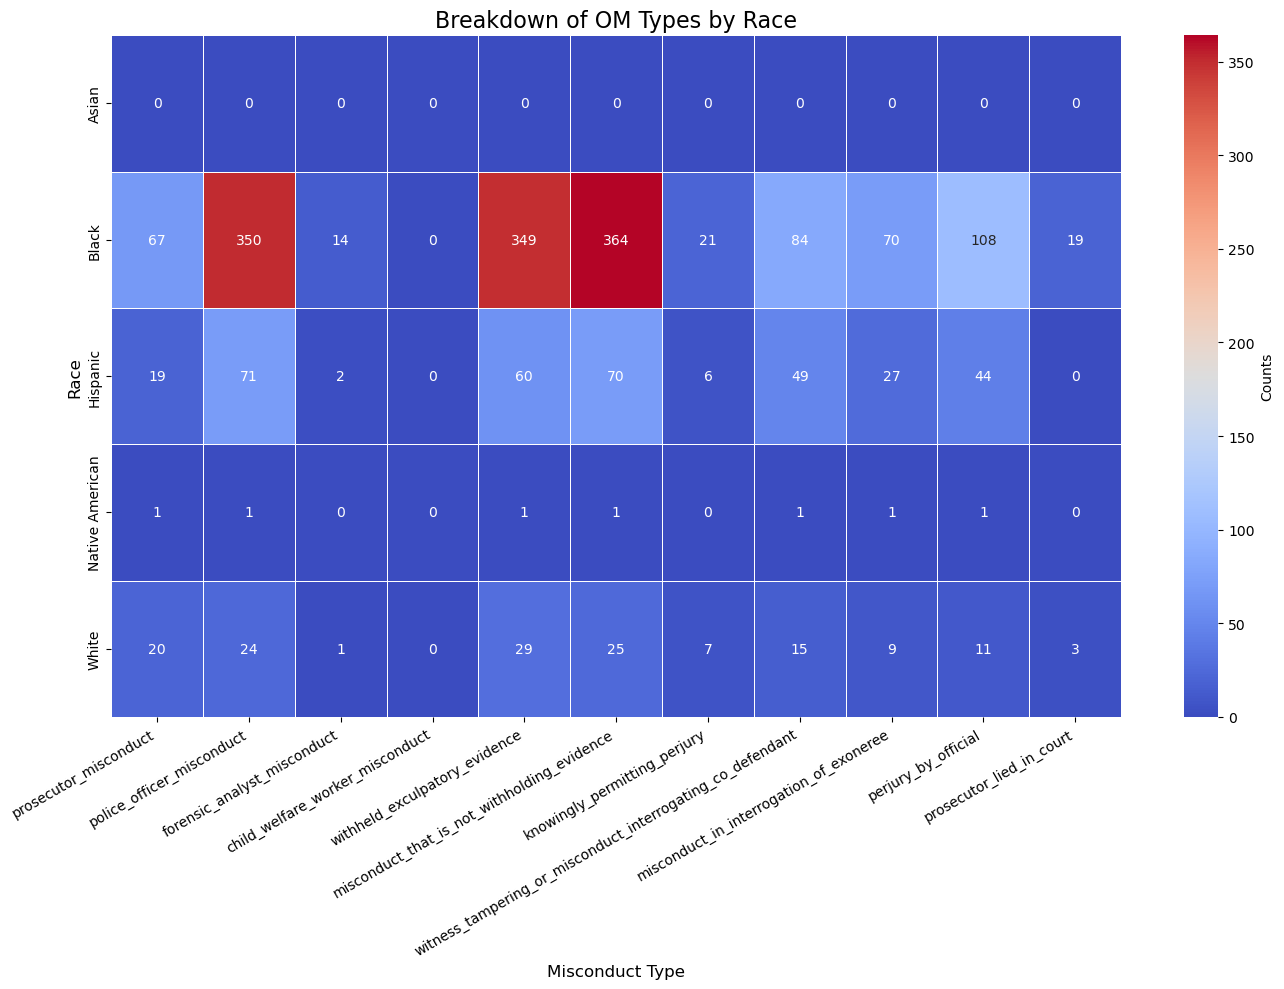

In [558]:
# Aggregate each misconduct tag by race
misconduct_by_race = exon_df.groupby('race')[misconduct_tags].sum()

# Heatmap of misconduct types by race with improved layout
plt.figure(figsize=(14, 10))  # Adjust figure size for better spacing
sns.heatmap(
    misconduct_by_race, 
    annot=True, 
    cmap='coolwarm', 
    fmt='d', 
    linewidths=0.5, 
    cbar_kws={'label': 'Counts'},  # Add a color bar label
    xticklabels=True, 
    yticklabels=True
)
plt.title("Breakdown of OM Types by Race", fontsize=16)  # Larger title font size
plt.xlabel("Misconduct Type", fontsize=12)  # Larger x-axis label font size
plt.ylabel("Race", fontsize=12)  # Larger y-axis label font size
plt.xticks(rotation=30, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)  # Adjust y-axis label font size
plt.tight_layout()  # Optimize layout to avoid overlap
plt.show()

The heatmap reveals clear racial disparities in the distribution of police misconduct types. Black exonerees experience the highest counts across nearly every category, particularly in **police officer misconduct**, **withheld exculpatory evidence**, and **misconduct_that_is_not_withholding_evidence**, where counts exceed 300 in multiple instances. These numbers reflect a systemic pattern where Black individuals are overwhelmingly subjected to multiple forms of misconduct during wrongful convictions.

Hispanic exonerees follow but with much lower frequencies, most notably in **police officer misconduct** and **withheld exculpatory evidence**. While misconduct is still present, the lower counts compared to Black exonerees highlight the disproportionate burden carried by Black individuals.

White exonerees show smaller counts across all categories, with misconduct numbers rarely exceeding 30 in any type. For Native American and Asian exonerees, instances of police misconduct are virtually nonexistent in the dataset, which may indicate smaller representation or underreporting rather than an absence of misconduct.

The heatmap underscores how specific types of misconduct—such as withheld evidence and direct police misconduct—are disproportionately concentrated among Black exonerees, further reflecting systemic racial biases deeply embedded within the criminal legal system.  

## Misconduct Tags by County
The following examines the distribution of misconduct types across counties using a **heatmap**. Misconduct tags are aggregated by county to identify how various types of official misconduct appear across different regions. Each cell in the heatmap shows the frequency of a specific misconduct type within a particular county, with a color gradient reflecting the counts. Darker shades represent higher frequencies, while lighter shades indicate fewer instances. By visualizing the data this way, the analysis highlights regional differences in misconduct patterns, allowing for a clearer understanding of which counties report higher concentrations of specific misconduct types.  

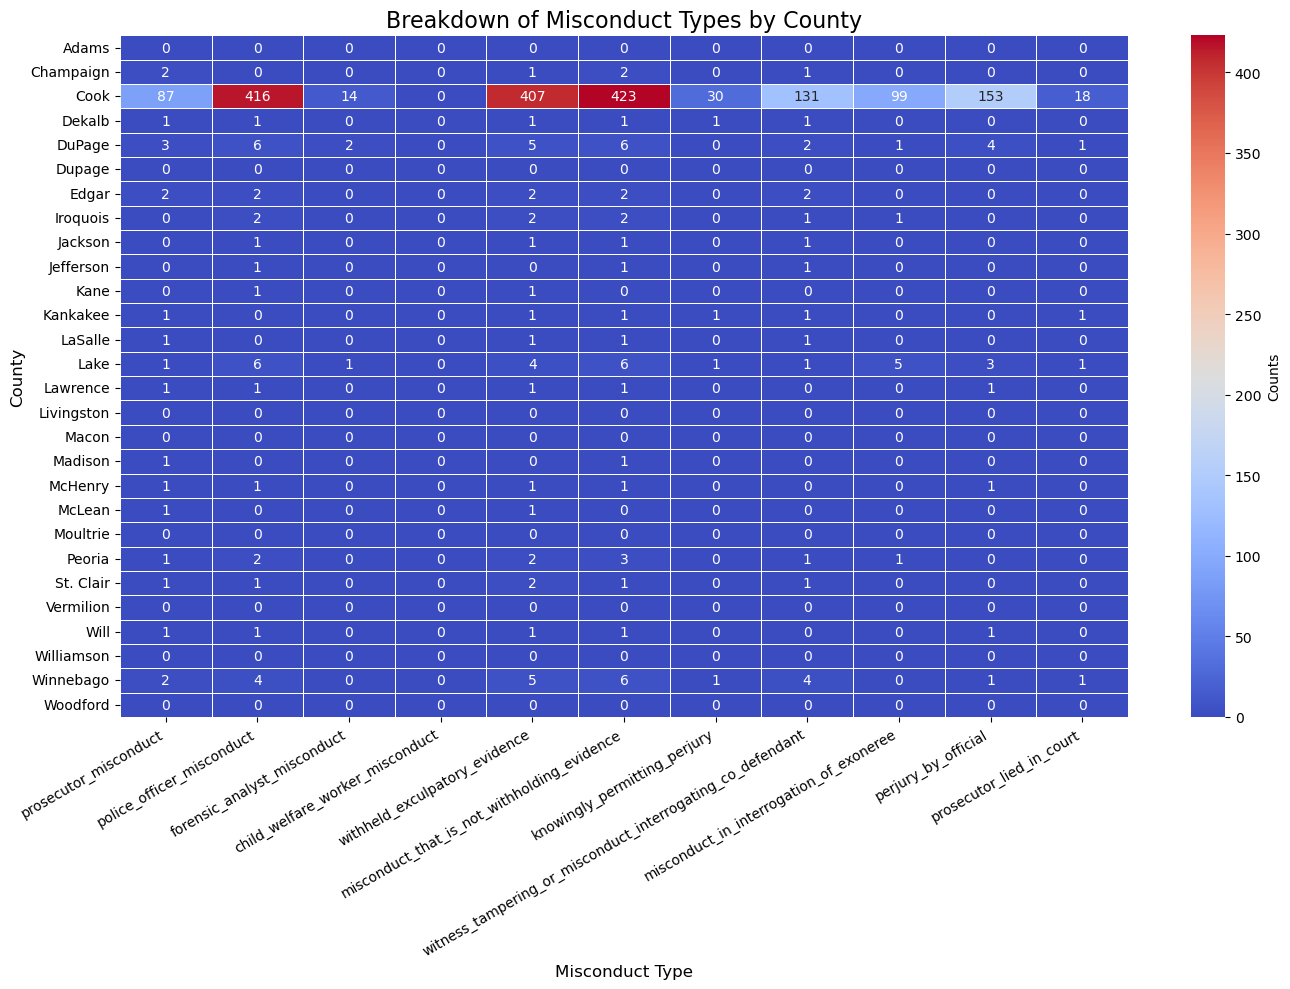

In [573]:
# Aggregate misconduct by county and type
misconduct_county = exon_df.groupby('county')[misconduct_tags].sum()

# Heatmap of misconduct types by county
plt.figure(figsize=(14, 10))
sns.heatmap(
    misconduct_county,
    annot=True,
    cmap='coolwarm',
    fmt='.0f',  # Format numbers as integers
    linewidths=0.5,
    cbar_kws={'label': 'Counts'}
)
plt.title("Breakdown of Misconduct Types by County", fontsize=16)
plt.xlabel("Misconduct Type", fontsize=12)
plt.ylabel("County", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


The heatmap highlights significant regional disparities in the prevalence of official misconduct types across Illinois counties. **Cook County** stands out with the highest counts across multiple misconduct categories, particularly in **police officer misconduct**, **withheld exculpatory evidence**, and **misconduct_that_is_not_withholding_evidence**, where counts exceed 400. This suggests that Cook County sees a disproportionate concentration of misconduct tied to wrongful convictions.  

Other counties, such as **Dekalb**, also report notable frequencies in several categories, though on a smaller scale. In contrast, most other counties show far fewer instances of misconduct, with many reporting near-zero counts across most categories.  

The stark concentration of misconduct in Cook County underscores systemic issues that may be tied to larger caseloads, greater population density, or more thoroughly documented cases compared to rural counties. These findings reflect broader patterns of geographic inequities in how misconduct is identified and recorded within the criminal legal system.  

### Misconduct Tags by County and Race

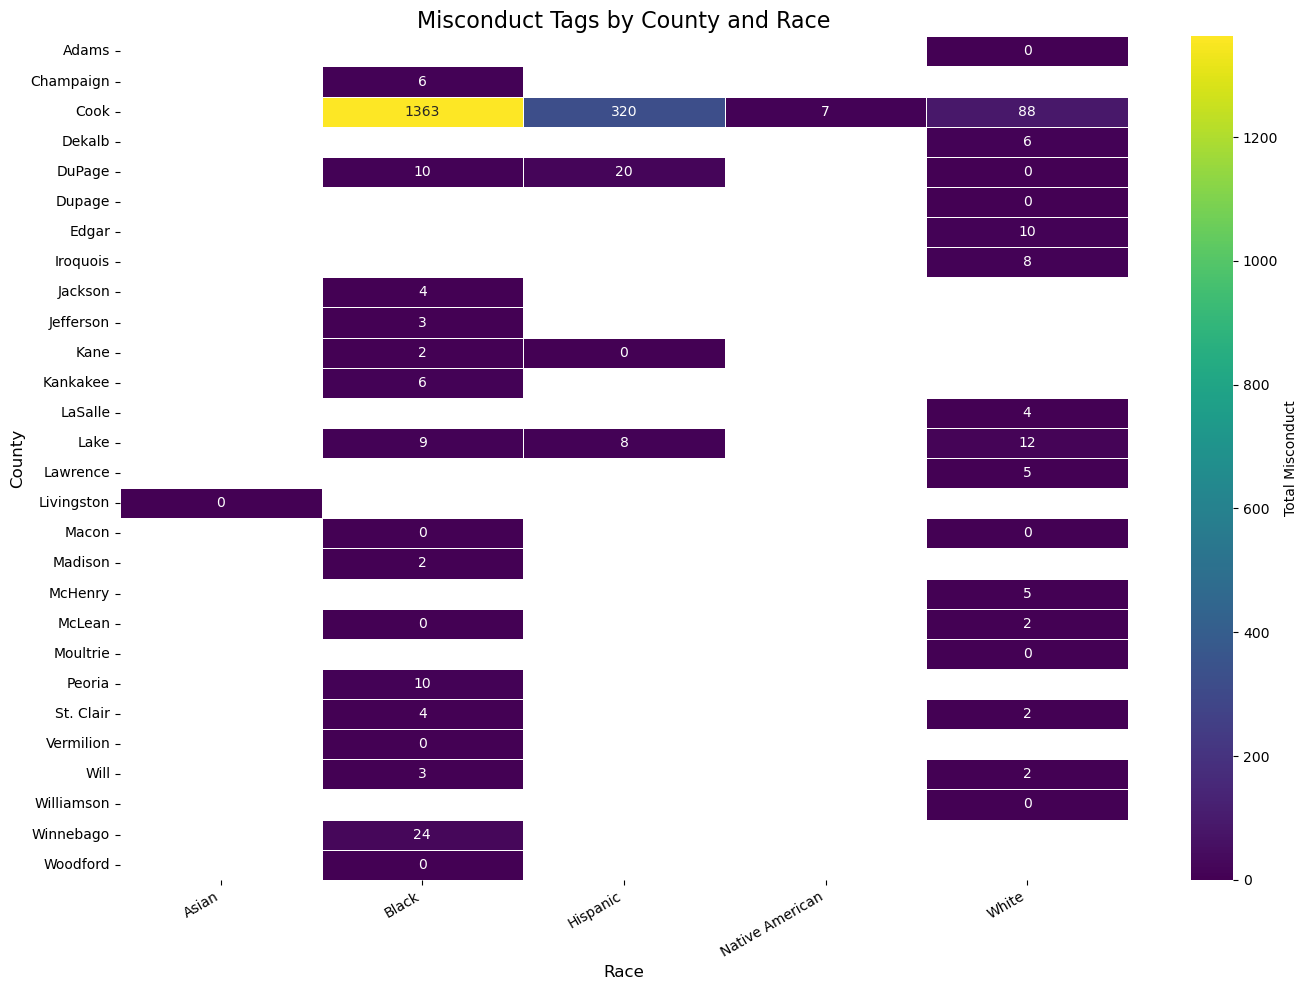

In [591]:
# Aggregate misconduct by county and race
misconduct_race_county = exon_df.groupby(['county', 'race'])['total_misconduct'].sum().unstack()

# Heatmap of misconduct by county and race
plt.figure(figsize=(14, 10))
sns.heatmap(
    misconduct_race_county,
    annot=True, 
    cmap='viridis', 
    fmt='.0f',  
    linewidths=0.5, 
    cbar_kws={'label': 'Total Misconduct'}
)
plt.title("Misconduct Tags by County and Race", fontsize=16)
plt.xlabel("Race", fontsize=12)
plt.ylabel("County", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  
plt.show()


The heatmap highlights significant racial and geographic disparities in official misconduct across Illinois counties. **Cook County** dominates the visualization, with Black exonerees experiencing an overwhelming concentration of misconduct tags—**1,363** in total—far surpassing all other racial groups and counties. This disparity underscores the disproportionate burden placed on Black individuals in urban regions like Cook County. Hispanic exonerees in Cook County also show elevated misconduct counts, though significantly lower than their Black counterparts. In other counties, misconduct tags are fewer and more evenly distributed. Counties like **Lake** and **Winnebago** report notable misconduct counts for Black exonerees, while White exonerees appear more frequently in rural counties like **LaSalle** and **McHenry**, though at much smaller scales. The data makes clear that official misconduct disproportionately affects Black exonerees, particularly in high-population urban counties like Cook. These findings highlight both systemic racial inequities and geographic concentration of wrongful convictions tied to misconduct.  

## Implications  
The analysis of misconduct tags in exoneration cases, when connected with earlier arrest data, highlights a clear pattern of **racialized injustice** within the criminal legal system. Black individuals not only face higher rates of arrests—often tied to over-policing in predominantly Black communities—but are also subjected to disproportionate levels of **official misconduct** that contribute to wrongful convictions. This double burden underscores how systemic racism permeates multiple stages of the justice process, from arrest to conviction to exoneration. Geographically, the concentration of misconduct in urban counties—most notably in **Cook County**, home to Chicago—reflects how densely populated areas with significant Black populations experience both over-policing and elevated rates of documented misconduct. The sheer scale of misconduct tags for Black exonerees in these regions exposes systemic failures in law enforcement and prosecutorial accountability. While rural areas report fewer cases, this does not diminish their relevance. Wrongful convictions remain a systemic issue across urban and rural regions, but the scale and visibility are amplified in urban areas. The data makes clear that wrongful convictions are not isolated incidents but part of a broader pattern, with Black individuals disproportionately bearing the brunt of these injustices.  
 

# Conclusions and Next Steps  

**The exploratory data analysis (EDA) uncovered systemic racial, geographic, and sentencing disparities deeply embedded in wrongful convictions, incarcerations, and over-policing for the state of Illinois** Black individuals account for the overwhelming majority of exonerees, disproportionately represented in severe crimes like murder and drug-related offenses, pointing to racialized patterns of over-policing and targeted enforcement. Hispanic individuals follow, with elevated wrongful convictions tied to drug-related cases, while White exonerees remain underrepresented. Geographically, Cook County —which encompasses Chicago—dominates both exoneration and arrest data, reflecting concentrated policing practices and systemic failures in densely populated urban regions. Rural counties report fewer wrongful convictions, yet overrepresentation ratios reveal that racial disparities persist even in areas with smaller minority populations. Additionally, the analysis of official misconduct highlights how Black exonerees face a disproportionate burden of misconduct tags, exposing structural flaws in law enforcement and prosecutorial accountability. The examination of sentence lengths** further amplifies these inequities, with Black individuals experiencing extreme outliers, and Hispanic exonerees showing the widest range of sentencing disparities. 

## Implications for Modeling
The findings from this EDA provide critical insights that will guide the next stages of the project. Key patterns, such as the **racial, geographic, and sentencing disparities** in wrongful convictions, highlight areas where predictive modeling can be applied to uncover systemic trends and risks. For **unsupervised learning**, clustering methods will be explored to identify **patterns of wrongful incarceration** based on variables such as race, location, and misconduct tags. These clusters can provide deeper insights into how wrongful convictions manifest across different demographics and geographic regions. For **supervised learning**, the focus will be on building models to **predict the probability of wrongful incarceration** based on demographic and exoneration data. The analysis will estimate average predicted probabilities across key variables, such as race and county, to uncover patterns of systemic disparities, ultimately highlighting the risk factors most strongly associated with wrongful convictions, providing a data-driven foundation for addressing these inequities and informing targeted policy reforms.  